# WavLM_base

In [33]:
#!pip install  transformers 
#!pip install --quiet datasets
!pip install pycm==3.5

In [5]:
from transformers import Wav2Vec2FeatureExtractor, WavLMForXVector
import torch
import librosa
import IPython.display as ipd
import numpy as np


In [ ]:
!mkdir output
!for f in /home/sadeghi/farsdot/*/*/*/*.wav; do ffmpeg -i "$f"  -ss 00:00:06 -t 00:00:06 -async 1 "${f%.*_n}.wav"; done

In [12]:
!ffmpeg -i /home/sadeghi/Downloads/002F01.wav  -ss 00:00:06 -t 00:00:06 -async 1 audio_farsdot8.wav

ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/sadeghi/anaconda3 --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from '/home/sadeghi/Downloads/002F01.wav':
  Duration: 00:01:52.75, bitrate: 352 kb/s
    

In [54]:
import os
spk2spch = {}
PATH = "/home/sadeghi/farsdot_enrollment2/"
for fname in next(os.walk(PATH))[2]:
    spk_id, _ = fname.split("F")
    speech_array, sample_rate = librosa.load(PATH + fname)
    speech_array = speech_array.squeeze().astype(np.float)
    speech_array = librosa.resample(np.array(speech_array), sample_rate, 16000)
    
    spk2spch[f"spk-{spk_id}"] = speech_array
print(spk2spch)

/tmp/ipykernel_1878002/1907658453.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  speech_array = speech_array.squeeze().astype(np.float)


{'spk-018': array([ 0.01194964,  0.01702773,  0.01484447, ...,  0.00293023,
       -0.02152201, -0.05005834]), 'spk-030': array([-4.49536756e-03, -1.52257812e-03, -1.66311182e-05, ...,
        2.40348028e-02,  1.78597756e-02,  2.46458855e-02]), 'spk-021': array([0.01639533, 0.01583714, 0.00998222, ..., 0.01186325, 0.01253703,
       0.01462473]), 'spk-004': array([-0.02638284, -0.05006207, -0.06947115, ..., -0.12248018,
       -0.16088817, -0.17212584]), 'spk-025': array([0.00574081, 0.00786249, 0.00613504, ..., 0.11327537, 0.08127753,
       0.083759  ]), 'spk-007': array([ 0.00866482, -0.00290502,  0.01424367, ...,  0.00214275,
        0.00349599,  0.0037599 ]), 'spk-002': array([ 0.01944956,  0.02410425,  0.02195049, ..., -0.1059502 ,
       -0.1007017 , -0.09305674]), 'spk-006': array([-0.06928651, -0.01166288,  0.06066464, ...,  0.00615853,
       -0.00426675,  0.00875077]), 'spk-011': array([ 0.00369659, -0.02638258, -0.01976043, ..., -0.0036571 ,
       -0.0028719 , -0.04345309]

In [55]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("/home/sadeghi/WavLM")
model = WavLMForXVector.from_pretrained("/home/sadeghi/WavLM")
threshold = 0.957
similarities = []

In [56]:
from os.path import exists

with open('/home/sadeghi/farsdot/trials') as f:
    for line in f:
        line = line.strip()
        spk_id, utt_id, target_nontarget = line.split()
        path = "/home/sadeghi/farsdot/"  + utt_id.split("-")[1] + ".wav.wav"
        if exists(path) is False:
            path = "/home/sadeghi/farsdot/"  + utt_id.split("-")[1] + ".WAV.WAV"
        
        speech_array2, sample_rate =librosa.load(path)
        print(path, spk_id, target_nontarget)
        speech_array2 = speech_array2.squeeze().astype(float)
        speech_array2 = librosa.resample(np.array(speech_array2), sample_rate, 16000)
        speech3 = [spk2spch[spk_id], speech_array2]
        
        inputs= feature_extractor(
            speech3,
            sampling_rate=16000,
            return_tensors="pt",
            padding=True)

        with torch.no_grad():
            embeddings = model(**inputs).embeddings

        embeddings = torch.nn.functional.normalize(embeddings, dim=-1).cpu()
        cosine_sim = torch.nn.CosineSimilarity(dim=-1)
        similarity = cosine_sim(embeddings[0], embeddings[1])
        similarities.append(similarity.item())
        print(similarity.item())

/home/sadeghi/farsdot/001F02.WAV.WAV spk-001 target
0.9767014980316162
/home/sadeghi/farsdot/001F03.WAV.WAV spk-001 target
0.9844593405723572
/home/sadeghi/farsdot/001F04.WAV.WAV spk-001 target
0.9834012985229492
/home/sadeghi/farsdot/001F05.WAV.WAV spk-001 target
0.9580065608024597
/home/sadeghi/farsdot/001F06.WAV.WAV spk-001 target
0.9560644626617432
/home/sadeghi/farsdot/001F07.WAV.WAV spk-001 target
0.9846614599227905
/home/sadeghi/farsdot/001F08.WAV.WAV spk-001 target
0.9726706147193909
/home/sadeghi/farsdot/001F09.WAV.WAV spk-001 target
0.9795389175415039
/home/sadeghi/farsdot/001F10.WAV.WAV spk-001 target
0.9701917767524719
/home/sadeghi/farsdot/002F02.wav.wav spk-001 nontarget
0.7021094560623169
/home/sadeghi/farsdot/002F03.wav.wav spk-001 nontarget
0.7650372385978699
/home/sadeghi/farsdot/002F04.wav.wav spk-001 nontarget
0.6177982687950134
/home/sadeghi/farsdot/002F05.wav.wav spk-001 nontarget
0.6900076866149902
/home/sadeghi/farsdot/002F06.wav.wav spk-001 nontarget
0.62662494

0.37064170837402344
/home/sadeghi/farsdot/013F06.WAV.WAV spk-001 nontarget
0.42122629284858704
/home/sadeghi/farsdot/013F07.WAV.WAV spk-001 nontarget
0.39740845561027527
/home/sadeghi/farsdot/013F08.WAV.WAV spk-001 nontarget
0.4501112699508667
/home/sadeghi/farsdot/013F09.WAV.WAV spk-001 nontarget
0.43713635206222534
/home/sadeghi/farsdot/013F10.WAV.WAV spk-001 nontarget
0.4004896581172943
/home/sadeghi/farsdot/014F02.WAV.WAV spk-001 nontarget
0.44016963243484497
/home/sadeghi/farsdot/014F03.WAV.WAV spk-001 nontarget
0.45376360416412354
/home/sadeghi/farsdot/014F04.WAV.WAV spk-001 nontarget
0.4426577687263489
/home/sadeghi/farsdot/014F05.WAV.WAV spk-001 nontarget
0.43421491980552673
/home/sadeghi/farsdot/014F06.WAV.WAV spk-001 nontarget
0.42050573229789734
/home/sadeghi/farsdot/014F07.WAV.WAV spk-001 nontarget
0.37756744027137756
/home/sadeghi/farsdot/014F08.WAV.WAV spk-001 nontarget
0.40690934658050537
/home/sadeghi/farsdot/014F09.WAV.WAV spk-001 nontarget
0.41948604583740234
/home/sa

0.7378687858581543
/home/sadeghi/farsdot/025F09.wav.wav spk-001 nontarget
0.7181535363197327
/home/sadeghi/farsdot/025F10.wav.wav spk-001 nontarget
0.7035039663314819
/home/sadeghi/farsdot/026F02.WAV.WAV spk-001 nontarget
0.802242636680603
/home/sadeghi/farsdot/026F03.WAV.WAV spk-001 nontarget
0.8316993117332458
/home/sadeghi/farsdot/026F04.WAV.WAV spk-001 nontarget
0.8267906308174133
/home/sadeghi/farsdot/026F05.WAV.WAV spk-001 nontarget
0.8345726728439331
/home/sadeghi/farsdot/026F06.WAV.WAV spk-001 nontarget
0.8346872329711914
/home/sadeghi/farsdot/026F07.WAV.WAV spk-001 nontarget
0.8030416965484619
/home/sadeghi/farsdot/026F08.WAV.WAV spk-001 nontarget
0.8299040198326111
/home/sadeghi/farsdot/026F09.WAV.WAV spk-001 nontarget
0.8188542723655701
/home/sadeghi/farsdot/026F10.WAV.WAV spk-001 nontarget
0.8495771884918213
/home/sadeghi/farsdot/027F02.wav.wav spk-001 nontarget
0.33805692195892334
/home/sadeghi/farsdot/027F03.wav.wav spk-001 nontarget
0.36095181107521057
/home/sadeghi/fars

0.8935198187828064
/home/sadeghi/farsdot/008F04.WAV.WAV spk-002 nontarget
0.8838537931442261
/home/sadeghi/farsdot/008F05.WAV.WAV spk-002 nontarget
0.8459517359733582
/home/sadeghi/farsdot/008F06.WAV.WAV spk-002 nontarget
0.8230487108230591
/home/sadeghi/farsdot/008F07.WAV.WAV spk-002 nontarget
0.8564949035644531
/home/sadeghi/farsdot/008F08.WAV.WAV spk-002 nontarget
0.9006596803665161
/home/sadeghi/farsdot/008F09.WAV.WAV spk-002 nontarget
0.8361566662788391
/home/sadeghi/farsdot/008F10.WAV.WAV spk-002 nontarget
0.8836625814437866
/home/sadeghi/farsdot/009F02.WAV.WAV spk-002 nontarget
0.932661235332489
/home/sadeghi/farsdot/009F03.WAV.WAV spk-002 nontarget
0.8907142877578735
/home/sadeghi/farsdot/009F04.WAV.WAV spk-002 nontarget
0.9286041855812073
/home/sadeghi/farsdot/009F05.WAV.WAV spk-002 nontarget
0.9250738620758057
/home/sadeghi/farsdot/009F06.WAV.WAV spk-002 nontarget
0.921363353729248
/home/sadeghi/farsdot/009F07.WAV.WAV spk-002 nontarget
0.7875176072120667
/home/sadeghi/farsdot

0.8755689263343811
/home/sadeghi/farsdot/020F07.WAV.WAV spk-002 nontarget
0.8312118649482727
/home/sadeghi/farsdot/020F08.WAV.WAV spk-002 nontarget
0.8346377015113831
/home/sadeghi/farsdot/020F09.WAV.WAV spk-002 nontarget
0.8987284898757935
/home/sadeghi/farsdot/020F10.WAV.WAV spk-002 nontarget
0.8387939929962158
/home/sadeghi/farsdot/021F02.WAV.WAV spk-002 nontarget
0.8146239519119263
/home/sadeghi/farsdot/021F03.WAV.WAV spk-002 nontarget
0.8528004288673401
/home/sadeghi/farsdot/021F04.WAV.WAV spk-002 nontarget
0.8373100757598877
/home/sadeghi/farsdot/021F05.WAV.WAV spk-002 nontarget
0.8081860542297363
/home/sadeghi/farsdot/021F06.WAV.WAV spk-002 nontarget
0.7921463847160339
/home/sadeghi/farsdot/021F07.WAV.WAV spk-002 nontarget
0.8175100684165955
/home/sadeghi/farsdot/021F08.WAV.WAV spk-002 nontarget
0.8318221569061279
/home/sadeghi/farsdot/021F09.WAV.WAV spk-002 nontarget
0.8697190284729004
/home/sadeghi/farsdot/021F10.WAV.WAV spk-002 nontarget
0.8575235605239868
/home/sadeghi/farsd

0.4684702754020691
/home/sadeghi/farsdot/002F10.wav.wav spk-003 nontarget
0.46945399045944214
/home/sadeghi/farsdot/003F02.WAV.WAV spk-003 target
0.9816869497299194
/home/sadeghi/farsdot/003F03.WAV.WAV spk-003 target
0.9821161031723022
/home/sadeghi/farsdot/003F04.WAV.WAV spk-003 target
0.9825763702392578
/home/sadeghi/farsdot/003F05.WAV.WAV spk-003 target
0.9837803244590759
/home/sadeghi/farsdot/003F06.WAV.WAV spk-003 target
0.9838473796844482
/home/sadeghi/farsdot/003F07.WAV.WAV spk-003 target
0.9837996363639832
/home/sadeghi/farsdot/003F08.WAV.WAV spk-003 target
0.9837577939033508
/home/sadeghi/farsdot/003F09.WAV.WAV spk-003 target
0.976240873336792
/home/sadeghi/farsdot/003F10.WAV.WAV spk-003 target
0.9763405323028564
/home/sadeghi/farsdot/004F02.WAV.WAV spk-003 nontarget
0.7487459182739258
/home/sadeghi/farsdot/004F03.WAV.WAV spk-003 nontarget
0.741223931312561
/home/sadeghi/farsdot/004F04.WAV.WAV spk-003 nontarget
0.7679764032363892
/home/sadeghi/farsdot/004F05.WAV.WAV spk-003 no

0.7888364791870117
/home/sadeghi/farsdot/015F05.WAV.WAV spk-003 nontarget
0.7615464329719543
/home/sadeghi/farsdot/015F06.WAV.WAV spk-003 nontarget
0.8115764260292053
/home/sadeghi/farsdot/015F07.WAV.WAV spk-003 nontarget
0.7635874152183533
/home/sadeghi/farsdot/015F08.WAV.WAV spk-003 nontarget
0.8100540637969971
/home/sadeghi/farsdot/015F09.WAV.WAV spk-003 nontarget
0.8256933689117432
/home/sadeghi/farsdot/015F10.WAV.WAV spk-003 nontarget
0.8171795010566711
/home/sadeghi/farsdot/016F02.WAV.WAV spk-003 nontarget
0.4564545750617981
/home/sadeghi/farsdot/016F03.WAV.WAV spk-003 nontarget
0.44654393196105957
/home/sadeghi/farsdot/016F04.WAV.WAV spk-003 nontarget
0.46063920855522156
/home/sadeghi/farsdot/016F05.WAV.WAV spk-003 nontarget
0.45296019315719604
/home/sadeghi/farsdot/016F06.WAV.WAV spk-003 nontarget
0.4747827351093292
/home/sadeghi/farsdot/016F07.WAV.WAV spk-003 nontarget
0.4491351842880249
/home/sadeghi/farsdot/016F08.WAV.WAV spk-003 nontarget
0.501166582107544
/home/sadeghi/far

0.8602476716041565
/home/sadeghi/farsdot/027F08.wav.wav spk-003 nontarget
0.8775042295455933
/home/sadeghi/farsdot/027F09.wav.wav spk-003 nontarget
0.8880911469459534
/home/sadeghi/farsdot/027F10.wav.wav spk-003 nontarget
0.8807209730148315
/home/sadeghi/farsdot/028F02.WAV.WAV spk-003 nontarget
0.9105526208877563
/home/sadeghi/farsdot/028F03.WAV.WAV spk-003 nontarget
0.9107105135917664
/home/sadeghi/farsdot/028F04.WAV.WAV spk-003 nontarget
0.9293885231018066
/home/sadeghi/farsdot/028F05.WAV.WAV spk-003 nontarget
0.9194515347480774
/home/sadeghi/farsdot/028F06.WAV.WAV spk-003 nontarget
0.900856077671051
/home/sadeghi/farsdot/028F07.WAV.WAV spk-003 nontarget
0.8933987617492676
/home/sadeghi/farsdot/028F08.WAV.WAV spk-003 nontarget
0.9001145362854004
/home/sadeghi/farsdot/028F09.WAV.WAV spk-003 nontarget
0.8854356408119202
/home/sadeghi/farsdot/028F10.WAV.WAV spk-003 nontarget
0.928493082523346
/home/sadeghi/farsdot/029F02.WAV.WAV spk-003 nontarget
0.44945985078811646
/home/sadeghi/farsdo

0.9188103079795837
/home/sadeghi/farsdot/010F03.WAV.WAV spk-004 nontarget
0.8904958367347717
/home/sadeghi/farsdot/010F04.WAV.WAV spk-004 nontarget
0.8756710886955261
/home/sadeghi/farsdot/010F05.WAV.WAV spk-004 nontarget
0.8207433819770813
/home/sadeghi/farsdot/010F06.WAV.WAV spk-004 nontarget
0.8636390566825867
/home/sadeghi/farsdot/010F07.WAV.WAV spk-004 nontarget
0.8405655026435852
/home/sadeghi/farsdot/010F08.WAV.WAV spk-004 nontarget
0.8375834226608276
/home/sadeghi/farsdot/010F09.WAV.WAV spk-004 nontarget
0.8455067873001099
/home/sadeghi/farsdot/010F10.WAV.WAV spk-004 nontarget
0.828957200050354
/home/sadeghi/farsdot/011F02.WAV.WAV spk-004 nontarget
0.7217217087745667
/home/sadeghi/farsdot/011F03.WAV.WAV spk-004 nontarget
0.6789484620094299
/home/sadeghi/farsdot/011F04.WAV.WAV spk-004 nontarget
0.7210065722465515
/home/sadeghi/farsdot/011F05.WAV.WAV spk-004 nontarget
0.6675920486450195
/home/sadeghi/farsdot/011F06.WAV.WAV spk-004 nontarget
0.6009175777435303
/home/sadeghi/farsdo

0.6987091898918152
/home/sadeghi/farsdot/022F06.WAV.WAV spk-004 nontarget
0.660460889339447
/home/sadeghi/farsdot/022F07.WAV.WAV spk-004 nontarget
0.6611478924751282
/home/sadeghi/farsdot/022F08.WAV.WAV spk-004 nontarget
0.6881491541862488
/home/sadeghi/farsdot/022F09.WAV.WAV spk-004 nontarget
0.72688889503479
/home/sadeghi/farsdot/022F10.WAV.WAV spk-004 nontarget
0.7086686491966248
/home/sadeghi/farsdot/023F02.WAV.WAV spk-004 nontarget
0.6229524612426758
/home/sadeghi/farsdot/023F03.WAV.WAV spk-004 nontarget
0.6792624592781067
/home/sadeghi/farsdot/023F04.WAV.WAV spk-004 nontarget
0.6891762018203735
/home/sadeghi/farsdot/023F05.WAV.WAV spk-004 nontarget
0.5990051031112671
/home/sadeghi/farsdot/023F06.WAV.WAV spk-004 nontarget
0.6788619160652161
/home/sadeghi/farsdot/023F07.WAV.WAV spk-004 nontarget
0.6399540305137634
/home/sadeghi/farsdot/023F08.WAV.WAV spk-004 nontarget
0.6425347924232483
/home/sadeghi/farsdot/023F09.WAV.WAV spk-004 nontarget
0.5893084406852722
/home/sadeghi/farsdot/

0.7997275590896606
/home/sadeghi/farsdot/004F09.WAV.WAV spk-005 nontarget
0.7878945469856262
/home/sadeghi/farsdot/004F10.WAV.WAV spk-005 nontarget
0.8350692987442017
/home/sadeghi/farsdot/005F02.WAV.WAV spk-005 target
0.9847527146339417
/home/sadeghi/farsdot/005F03.WAV.WAV spk-005 target
0.9790483713150024
/home/sadeghi/farsdot/005F04.WAV.WAV spk-005 target
0.9578924179077148
/home/sadeghi/farsdot/005F05.WAV.WAV spk-005 target
0.9786177277565002
/home/sadeghi/farsdot/005F06.WAV.WAV spk-005 target
0.9822549819946289
/home/sadeghi/farsdot/005F07.WAV.WAV spk-005 target
0.9808122515678406
/home/sadeghi/farsdot/005F08.WAV.WAV spk-005 target
0.9698169231414795
/home/sadeghi/farsdot/005F09.WAV.WAV spk-005 target
0.9634866714477539
/home/sadeghi/farsdot/005F10.WAV.WAV spk-005 target
0.9665541052818298
/home/sadeghi/farsdot/006F02.WAV.WAV spk-005 nontarget
0.6946645975112915
/home/sadeghi/farsdot/006F03.WAV.WAV spk-005 nontarget
0.6659321188926697
/home/sadeghi/farsdot/006F04.WAV.WAV spk-005 n

0.49221163988113403
/home/sadeghi/farsdot/017F04.WAV.WAV spk-005 nontarget
0.5607391595840454
/home/sadeghi/farsdot/017F05.WAV.WAV spk-005 nontarget
0.5647901296615601
/home/sadeghi/farsdot/017F06.WAV.WAV spk-005 nontarget
0.5423850417137146
/home/sadeghi/farsdot/017F07.WAV.WAV spk-005 nontarget
0.5954354405403137
/home/sadeghi/farsdot/017F08.WAV.WAV spk-005 nontarget
0.5903961658477783
/home/sadeghi/farsdot/017F09.wav.wav spk-005 nontarget
0.577793300151825
/home/sadeghi/farsdot/017F10.wav.wav spk-005 nontarget
0.5589919090270996
/home/sadeghi/farsdot/018F02.WAV.WAV spk-005 nontarget
0.7237935066223145
/home/sadeghi/farsdot/018F03.WAV.WAV spk-005 nontarget
0.6894838809967041
/home/sadeghi/farsdot/018F04.WAV.WAV spk-005 nontarget
0.7350594997406006
/home/sadeghi/farsdot/018F05.WAV.WAV spk-005 nontarget
0.7306636571884155
/home/sadeghi/farsdot/018F06.WAV.WAV spk-005 nontarget
0.7242307662963867
/home/sadeghi/farsdot/018F07.WAV.WAV spk-005 nontarget
0.663901150226593
/home/sadeghi/farsdo

0.828203022480011
/home/sadeghi/farsdot/029F07.WAV.WAV spk-005 nontarget
0.8922172784805298
/home/sadeghi/farsdot/029F08.WAV.WAV spk-005 nontarget
0.8396713137626648
/home/sadeghi/farsdot/029F09.WAV.WAV spk-005 nontarget
0.8916742205619812
/home/sadeghi/farsdot/029F10.WAV.WAV spk-005 nontarget
0.8871701955795288
/home/sadeghi/farsdot/030F02.WAV.WAV spk-005 nontarget
0.8846509456634521
/home/sadeghi/farsdot/030F03.WAV.WAV spk-005 nontarget
0.910423219203949
/home/sadeghi/farsdot/030F04.WAV.WAV spk-005 nontarget
0.8840509057044983
/home/sadeghi/farsdot/030F05.WAV.WAV spk-005 nontarget
0.893366813659668
/home/sadeghi/farsdot/030F06.WAV.WAV spk-005 nontarget
0.8919905424118042
/home/sadeghi/farsdot/030F07.WAV.WAV spk-005 nontarget
0.8780285716056824
/home/sadeghi/farsdot/030F08.WAV.WAV spk-005 nontarget
0.8871475458145142
/home/sadeghi/farsdot/030F09.WAV.WAV spk-005 nontarget
0.8873658180236816
/home/sadeghi/farsdot/030F10.WAV.WAV spk-005 nontarget
0.8989969491958618
/home/sadeghi/farsdot/

0.4639536142349243
/home/sadeghi/farsdot/011F10.WAV.WAV spk-006 nontarget
0.46171149611473083
/home/sadeghi/farsdot/012F02.WAV.WAV spk-006 nontarget
0.4582681655883789
/home/sadeghi/farsdot/012F03.WAV.WAV spk-006 nontarget
0.5061296224594116
/home/sadeghi/farsdot/012F04.WAV.WAV spk-006 nontarget
0.49786266684532166
/home/sadeghi/farsdot/012F05.WAV.WAV spk-006 nontarget
0.48680955171585083
/home/sadeghi/farsdot/012F06.WAV.WAV spk-006 nontarget
0.38694849610328674
/home/sadeghi/farsdot/012F07.WAV.WAV spk-006 nontarget
0.45007532835006714
/home/sadeghi/farsdot/012F08.WAV.WAV spk-006 nontarget
0.4094964861869812
/home/sadeghi/farsdot/012F09.WAV.WAV spk-006 nontarget
0.48443150520324707
/home/sadeghi/farsdot/012F10.WAV.WAV spk-006 nontarget
0.4528023302555084
/home/sadeghi/farsdot/013F02.WAV.WAV spk-006 nontarget
0.870378315448761
/home/sadeghi/farsdot/013F03.WAV.WAV spk-006 nontarget
0.8284909129142761
/home/sadeghi/farsdot/013F04.WAV.WAV spk-006 nontarget
0.7963674068450928
/home/sadeghi/

0.335166335105896
/home/sadeghi/farsdot/024F04.WAV.WAV spk-006 nontarget
0.3596384525299072
/home/sadeghi/farsdot/024F05.WAV.WAV spk-006 nontarget
0.3366701900959015
/home/sadeghi/farsdot/024F06.WAV.WAV spk-006 nontarget
0.3366086781024933
/home/sadeghi/farsdot/024F07.WAV.WAV spk-006 nontarget
0.40216052532196045
/home/sadeghi/farsdot/024F08.WAV.WAV spk-006 nontarget
0.3418920934200287
/home/sadeghi/farsdot/024F09.WAV.WAV spk-006 nontarget
0.406268835067749
/home/sadeghi/farsdot/024F10.WAV.WAV spk-006 nontarget
0.35525575280189514
/home/sadeghi/farsdot/025F02.wav.wav spk-006 nontarget
0.49118876457214355
/home/sadeghi/farsdot/025F03.wav.wav spk-006 nontarget
0.5040261149406433
/home/sadeghi/farsdot/025F04.wav.wav spk-006 nontarget
0.40205222368240356
/home/sadeghi/farsdot/025F05.wav.wav spk-006 nontarget
0.5508338809013367
/home/sadeghi/farsdot/025F06.wav.wav spk-006 nontarget
0.3800422251224518
/home/sadeghi/farsdot/025F07.wav.wav spk-006 nontarget
0.45290088653564453
/home/sadeghi/fa

0.5271380543708801
/home/sadeghi/farsdot/006F07.WAV.WAV spk-007 nontarget
0.5625378489494324
/home/sadeghi/farsdot/006F08.WAV.WAV spk-007 nontarget
0.5401086211204529
/home/sadeghi/farsdot/006F09.WAV.WAV spk-007 nontarget
0.4978973865509033
/home/sadeghi/farsdot/006F10.WAV.WAV spk-007 nontarget
0.5360289216041565
/home/sadeghi/farsdot/007F02.WAV.WAV spk-007 target
0.9682689905166626
/home/sadeghi/farsdot/007F03.WAV.WAV spk-007 target
0.9426668286323547
/home/sadeghi/farsdot/007F04.WAV.WAV spk-007 target
0.9242857694625854
/home/sadeghi/farsdot/007F05.WAV.WAV spk-007 target
0.9686735272407532
/home/sadeghi/farsdot/007F06.WAV.WAV spk-007 target
0.9507250189781189
/home/sadeghi/farsdot/007F07.WAV.WAV spk-007 target
0.9538300037384033
/home/sadeghi/farsdot/007F08.WAV.WAV spk-007 target
0.9557533860206604
/home/sadeghi/farsdot/007F09.WAV.WAV spk-007 target
0.9732909798622131
/home/sadeghi/farsdot/007F10.WAV.WAV spk-007 target
0.9554117918014526
/home/sadeghi/farsdot/008F02.WAV.WAV spk-007 n

0.576330840587616
/home/sadeghi/farsdot/019F02.WAV.WAV spk-007 nontarget
0.6086532473564148
/home/sadeghi/farsdot/019F03.WAV.WAV spk-007 nontarget
0.5634574890136719
/home/sadeghi/farsdot/019F04.WAV.WAV spk-007 nontarget
0.5049297213554382
/home/sadeghi/farsdot/019F05.WAV.WAV spk-007 nontarget
0.6005241870880127
/home/sadeghi/farsdot/019F06.WAV.WAV spk-007 nontarget
0.574563205242157
/home/sadeghi/farsdot/019F07.WAV.WAV spk-007 nontarget
0.5905163884162903
/home/sadeghi/farsdot/019F08.WAV.WAV spk-007 nontarget
0.5861802101135254
/home/sadeghi/farsdot/019F09.WAV.WAV spk-007 nontarget
0.5716585516929626
/home/sadeghi/farsdot/019F10.WAV.WAV spk-007 nontarget
0.5258952379226685
/home/sadeghi/farsdot/020F02.WAV.WAV spk-007 nontarget
0.8845441937446594
/home/sadeghi/farsdot/020F03.WAV.WAV spk-007 nontarget
0.898603618144989
/home/sadeghi/farsdot/020F04.WAV.WAV spk-007 nontarget
0.886579155921936
/home/sadeghi/farsdot/020F05.WAV.WAV spk-007 nontarget
0.8952942490577698
/home/sadeghi/farsdot/0

0.7601273059844971
/home/sadeghi/farsdot/001F05.WAV.WAV spk-008 nontarget
0.8130064010620117
/home/sadeghi/farsdot/001F06.WAV.WAV spk-008 nontarget
0.7879396080970764
/home/sadeghi/farsdot/001F07.WAV.WAV spk-008 nontarget
0.739301323890686
/home/sadeghi/farsdot/001F08.WAV.WAV spk-008 nontarget
0.7807247638702393
/home/sadeghi/farsdot/001F09.WAV.WAV spk-008 nontarget
0.7605717778205872
/home/sadeghi/farsdot/001F10.WAV.WAV spk-008 nontarget
0.8112776875495911
/home/sadeghi/farsdot/002F02.wav.wav spk-008 nontarget
0.8933410048484802
/home/sadeghi/farsdot/002F03.wav.wav spk-008 nontarget
0.913842499256134
/home/sadeghi/farsdot/002F04.wav.wav spk-008 nontarget
0.931181788444519
/home/sadeghi/farsdot/002F05.wav.wav spk-008 nontarget
0.9005086421966553
/home/sadeghi/farsdot/002F06.wav.wav spk-008 nontarget
0.923717200756073
/home/sadeghi/farsdot/002F07.wav.wav spk-008 nontarget
0.9330288767814636
/home/sadeghi/farsdot/002F08.wav.wav spk-008 nontarget
0.9205616116523743
/home/sadeghi/farsdot/0

0.6498669981956482
/home/sadeghi/farsdot/013F09.WAV.WAV spk-008 nontarget
0.6989765763282776
/home/sadeghi/farsdot/013F10.WAV.WAV spk-008 nontarget
0.6088758111000061
/home/sadeghi/farsdot/014F02.WAV.WAV spk-008 nontarget
0.512144923210144
/home/sadeghi/farsdot/014F03.WAV.WAV spk-008 nontarget
0.548555850982666
/home/sadeghi/farsdot/014F04.WAV.WAV spk-008 nontarget
0.5465579628944397
/home/sadeghi/farsdot/014F05.WAV.WAV spk-008 nontarget
0.5187363624572754
/home/sadeghi/farsdot/014F06.WAV.WAV spk-008 nontarget
0.5173527002334595
/home/sadeghi/farsdot/014F07.WAV.WAV spk-008 nontarget
0.48302051424980164
/home/sadeghi/farsdot/014F08.WAV.WAV spk-008 nontarget
0.4645872116088867
/home/sadeghi/farsdot/014F09.WAV.WAV spk-008 nontarget
0.507925808429718
/home/sadeghi/farsdot/014F10.WAV.WAV spk-008 nontarget
0.4717540740966797
/home/sadeghi/farsdot/015F02.WAV.WAV spk-008 nontarget
0.6594972610473633
/home/sadeghi/farsdot/015F03.WAV.WAV spk-008 nontarget
0.7269814610481262
/home/sadeghi/farsdot

0.719063401222229
/home/sadeghi/farsdot/026F03.WAV.WAV spk-008 nontarget
0.7673574686050415
/home/sadeghi/farsdot/026F04.WAV.WAV spk-008 nontarget
0.7299800515174866
/home/sadeghi/farsdot/026F05.WAV.WAV spk-008 nontarget
0.7404499053955078
/home/sadeghi/farsdot/026F06.WAV.WAV spk-008 nontarget
0.7244343757629395
/home/sadeghi/farsdot/026F07.WAV.WAV spk-008 nontarget
0.7797531485557556
/home/sadeghi/farsdot/026F08.WAV.WAV spk-008 nontarget
0.7465131282806396
/home/sadeghi/farsdot/026F09.WAV.WAV spk-008 nontarget
0.7946188449859619
/home/sadeghi/farsdot/026F10.WAV.WAV spk-008 nontarget
0.7241454720497131
/home/sadeghi/farsdot/027F02.wav.wav spk-008 nontarget
0.5031965970993042
/home/sadeghi/farsdot/027F03.wav.wav spk-008 nontarget
0.4744587540626526
/home/sadeghi/farsdot/027F04.wav.wav spk-008 nontarget
0.5401796698570251
/home/sadeghi/farsdot/027F05.wav.wav spk-008 nontarget
0.5084290504455566
/home/sadeghi/farsdot/027F06.wav.wav spk-008 nontarget
0.5253944993019104
/home/sadeghi/farsdo

0.8740750551223755
/home/sadeghi/farsdot/008F06.WAV.WAV spk-009 nontarget
0.8512378334999084
/home/sadeghi/farsdot/008F07.WAV.WAV spk-009 nontarget
0.9166160225868225
/home/sadeghi/farsdot/008F08.WAV.WAV spk-009 nontarget
0.917852520942688
/home/sadeghi/farsdot/008F09.WAV.WAV spk-009 nontarget
0.8604562282562256
/home/sadeghi/farsdot/008F10.WAV.WAV spk-009 nontarget
0.9336804151535034
/home/sadeghi/farsdot/009F02.WAV.WAV spk-009 target
0.9762278199195862
/home/sadeghi/farsdot/009F03.WAV.WAV spk-009 target
0.9744101762771606
/home/sadeghi/farsdot/009F04.WAV.WAV spk-009 target
0.9659468531608582
/home/sadeghi/farsdot/009F05.WAV.WAV spk-009 target
0.9752489924430847
/home/sadeghi/farsdot/009F06.WAV.WAV spk-009 target
0.9729588627815247
/home/sadeghi/farsdot/009F07.WAV.WAV spk-009 target
0.9364191293716431
/home/sadeghi/farsdot/009F08.WAV.WAV spk-009 target
0.9761552810668945
/home/sadeghi/farsdot/009F09.WAV.WAV spk-009 target
0.9621989727020264
/home/sadeghi/farsdot/009F10.WAV.WAV spk-009

0.8692187666893005
/home/sadeghi/farsdot/020F09.WAV.WAV spk-009 nontarget
0.9241918325424194
/home/sadeghi/farsdot/020F10.WAV.WAV spk-009 nontarget
0.8303122520446777
/home/sadeghi/farsdot/021F02.WAV.WAV spk-009 nontarget
0.938578724861145
/home/sadeghi/farsdot/021F03.WAV.WAV spk-009 nontarget
0.9361399412155151
/home/sadeghi/farsdot/021F04.WAV.WAV spk-009 nontarget
0.9240819811820984
/home/sadeghi/farsdot/021F05.WAV.WAV spk-009 nontarget
0.9218621850013733
/home/sadeghi/farsdot/021F06.WAV.WAV spk-009 nontarget
0.9078032970428467
/home/sadeghi/farsdot/021F07.WAV.WAV spk-009 nontarget
0.9446786046028137
/home/sadeghi/farsdot/021F08.WAV.WAV spk-009 nontarget
0.9566494226455688
/home/sadeghi/farsdot/021F09.WAV.WAV spk-009 nontarget
0.942391574382782
/home/sadeghi/farsdot/021F10.WAV.WAV spk-009 nontarget
0.9384884834289551
/home/sadeghi/farsdot/022F02.WAV.WAV spk-009 nontarget
0.4393790066242218
/home/sadeghi/farsdot/022F03.WAV.WAV spk-009 nontarget
0.405972421169281
/home/sadeghi/farsdot/

0.6767326593399048
/home/sadeghi/farsdot/003F03.WAV.WAV spk-010 nontarget
0.6717123985290527
/home/sadeghi/farsdot/003F04.WAV.WAV spk-010 nontarget
0.6578691601753235
/home/sadeghi/farsdot/003F05.WAV.WAV spk-010 nontarget
0.6572245955467224
/home/sadeghi/farsdot/003F06.WAV.WAV spk-010 nontarget
0.6706642508506775
/home/sadeghi/farsdot/003F07.WAV.WAV spk-010 nontarget
0.7114827632904053
/home/sadeghi/farsdot/003F08.WAV.WAV spk-010 nontarget
0.6759172677993774
/home/sadeghi/farsdot/003F09.WAV.WAV spk-010 nontarget
0.7453105449676514
/home/sadeghi/farsdot/003F10.WAV.WAV spk-010 nontarget
0.6700093746185303
/home/sadeghi/farsdot/004F02.WAV.WAV spk-010 nontarget
0.8474531769752502
/home/sadeghi/farsdot/004F03.WAV.WAV spk-010 nontarget
0.8726888298988342
/home/sadeghi/farsdot/004F04.WAV.WAV spk-010 nontarget
0.8779242634773254
/home/sadeghi/farsdot/004F05.WAV.WAV spk-010 nontarget
0.8770261406898499
/home/sadeghi/farsdot/004F06.WAV.WAV spk-010 nontarget
0.8371883630752563
/home/sadeghi/farsd

0.8599469065666199
/home/sadeghi/farsdot/015F07.WAV.WAV spk-010 nontarget
0.8935070037841797
/home/sadeghi/farsdot/015F08.WAV.WAV spk-010 nontarget
0.8267693519592285
/home/sadeghi/farsdot/015F09.WAV.WAV spk-010 nontarget
0.8449970483779907
/home/sadeghi/farsdot/015F10.WAV.WAV spk-010 nontarget
0.8509407043457031
/home/sadeghi/farsdot/016F02.WAV.WAV spk-010 nontarget
0.8704700469970703
/home/sadeghi/farsdot/016F03.WAV.WAV spk-010 nontarget
0.8327487111091614
/home/sadeghi/farsdot/016F04.WAV.WAV spk-010 nontarget
0.8562283515930176
/home/sadeghi/farsdot/016F05.WAV.WAV spk-010 nontarget
0.8650275468826294
/home/sadeghi/farsdot/016F06.WAV.WAV spk-010 nontarget
0.8563125729560852
/home/sadeghi/farsdot/016F07.WAV.WAV spk-010 nontarget
0.8395397067070007
/home/sadeghi/farsdot/016F08.WAV.WAV spk-010 nontarget
0.8522091507911682
/home/sadeghi/farsdot/016F09.WAV.WAV spk-010 nontarget
0.8926751017570496
/home/sadeghi/farsdot/016F10.WAV.WAV spk-010 nontarget
0.8360306620597839
/home/sadeghi/farsd

0.6923317313194275
/home/sadeghi/farsdot/027F10.wav.wav spk-010 nontarget
0.5509579181671143
/home/sadeghi/farsdot/028F02.WAV.WAV spk-010 nontarget
0.800210177898407
/home/sadeghi/farsdot/028F03.WAV.WAV spk-010 nontarget
0.7692810297012329
/home/sadeghi/farsdot/028F04.WAV.WAV spk-010 nontarget
0.742740273475647
/home/sadeghi/farsdot/028F05.WAV.WAV spk-010 nontarget
0.7782972455024719
/home/sadeghi/farsdot/028F06.WAV.WAV spk-010 nontarget
0.6643104553222656
/home/sadeghi/farsdot/028F07.WAV.WAV spk-010 nontarget
0.7615299224853516
/home/sadeghi/farsdot/028F08.WAV.WAV spk-010 nontarget
0.7554924488067627
/home/sadeghi/farsdot/028F09.WAV.WAV spk-010 nontarget
0.8105183243751526
/home/sadeghi/farsdot/028F10.WAV.WAV spk-010 nontarget
0.7468059062957764
/home/sadeghi/farsdot/029F02.WAV.WAV spk-010 nontarget
0.8431816697120667
/home/sadeghi/farsdot/029F03.WAV.WAV spk-010 nontarget
0.8491663932800293
/home/sadeghi/farsdot/029F04.WAV.WAV spk-010 nontarget
0.8678417205810547
/home/sadeghi/farsdot

0.7673851251602173
/home/sadeghi/farsdot/010F04.WAV.WAV spk-011 nontarget
0.7417771220207214
/home/sadeghi/farsdot/010F05.WAV.WAV spk-011 nontarget
0.75429368019104
/home/sadeghi/farsdot/010F06.WAV.WAV spk-011 nontarget
0.726108968257904
/home/sadeghi/farsdot/010F07.WAV.WAV spk-011 nontarget
0.8303529620170593
/home/sadeghi/farsdot/010F08.WAV.WAV spk-011 nontarget
0.7852033376693726
/home/sadeghi/farsdot/010F09.WAV.WAV spk-011 nontarget
0.7953847050666809
/home/sadeghi/farsdot/010F10.WAV.WAV spk-011 nontarget
0.8004382848739624
/home/sadeghi/farsdot/011F02.WAV.WAV spk-011 target
0.9674254655838013
/home/sadeghi/farsdot/011F03.WAV.WAV spk-011 target
0.9811693429946899
/home/sadeghi/farsdot/011F04.WAV.WAV spk-011 target
0.9732173681259155
/home/sadeghi/farsdot/011F05.WAV.WAV spk-011 target
0.9712822437286377
/home/sadeghi/farsdot/011F06.WAV.WAV spk-011 target
0.9771917462348938
/home/sadeghi/farsdot/011F07.WAV.WAV spk-011 target
0.9654848575592041
/home/sadeghi/farsdot/011F08.WAV.WAV spk

0.3875366449356079
/home/sadeghi/farsdot/022F08.WAV.WAV spk-011 nontarget
0.4450508654117584
/home/sadeghi/farsdot/022F09.WAV.WAV spk-011 nontarget
0.4079197645187378
/home/sadeghi/farsdot/022F10.WAV.WAV spk-011 nontarget
0.43057137727737427
/home/sadeghi/farsdot/023F02.WAV.WAV spk-011 nontarget
0.7788465619087219
/home/sadeghi/farsdot/023F03.WAV.WAV spk-011 nontarget
0.8332304358482361
/home/sadeghi/farsdot/023F04.WAV.WAV spk-011 nontarget
0.9019087553024292
/home/sadeghi/farsdot/023F05.WAV.WAV spk-011 nontarget
0.8060332536697388
/home/sadeghi/farsdot/023F06.WAV.WAV spk-011 nontarget
0.8514470458030701
/home/sadeghi/farsdot/023F07.WAV.WAV spk-011 nontarget
0.8647223711013794
/home/sadeghi/farsdot/023F08.WAV.WAV spk-011 nontarget
0.8306371569633484
/home/sadeghi/farsdot/023F09.WAV.WAV spk-011 nontarget
0.7919690012931824
/home/sadeghi/farsdot/023F10.WAV.WAV spk-011 nontarget
0.7626863121986389
/home/sadeghi/farsdot/024F02.WAV.WAV spk-011 nontarget
0.767081081867218
/home/sadeghi/farsd

0.7486639022827148
/home/sadeghi/farsdot/005F02.WAV.WAV spk-012 nontarget
0.9117859601974487
/home/sadeghi/farsdot/005F03.WAV.WAV spk-012 nontarget
0.9263626933097839
/home/sadeghi/farsdot/005F04.WAV.WAV spk-012 nontarget
0.9372482299804688
/home/sadeghi/farsdot/005F05.WAV.WAV spk-012 nontarget
0.9355289340019226
/home/sadeghi/farsdot/005F06.WAV.WAV spk-012 nontarget
0.9415962100028992
/home/sadeghi/farsdot/005F07.WAV.WAV spk-012 nontarget
0.9471578001976013
/home/sadeghi/farsdot/005F08.WAV.WAV spk-012 nontarget
0.9156256914138794
/home/sadeghi/farsdot/005F09.WAV.WAV spk-012 nontarget
0.9129297137260437
/home/sadeghi/farsdot/005F10.WAV.WAV spk-012 nontarget
0.9240190982818604
/home/sadeghi/farsdot/006F02.WAV.WAV spk-012 nontarget
0.5729380249977112
/home/sadeghi/farsdot/006F03.WAV.WAV spk-012 nontarget
0.5496293306350708
/home/sadeghi/farsdot/006F04.WAV.WAV spk-012 nontarget
0.5986337065696716
/home/sadeghi/farsdot/006F05.WAV.WAV spk-012 nontarget
0.629546046257019
/home/sadeghi/farsdo

0.4979827105998993
/home/sadeghi/farsdot/017F06.WAV.WAV spk-012 nontarget
0.4762950539588928
/home/sadeghi/farsdot/017F07.WAV.WAV spk-012 nontarget
0.5116665959358215
/home/sadeghi/farsdot/017F08.WAV.WAV spk-012 nontarget
0.5340756773948669
/home/sadeghi/farsdot/017F09.wav.wav spk-012 nontarget
0.5156818628311157
/home/sadeghi/farsdot/017F10.wav.wav spk-012 nontarget
0.5067100524902344
/home/sadeghi/farsdot/018F02.WAV.WAV spk-012 nontarget
0.6048610210418701
/home/sadeghi/farsdot/018F03.WAV.WAV spk-012 nontarget
0.5679797530174255
/home/sadeghi/farsdot/018F04.WAV.WAV spk-012 nontarget
0.6130245327949524
/home/sadeghi/farsdot/018F05.WAV.WAV spk-012 nontarget
0.6005356907844543
/home/sadeghi/farsdot/018F06.WAV.WAV spk-012 nontarget
0.593172013759613
/home/sadeghi/farsdot/018F07.WAV.WAV spk-012 nontarget
0.5333309769630432
/home/sadeghi/farsdot/018F08.WAV.WAV spk-012 nontarget
0.5386790037155151
/home/sadeghi/farsdot/018F09.WAV.WAV spk-012 nontarget
0.5683284997940063
/home/sadeghi/farsdo

0.8634684681892395
/home/sadeghi/farsdot/029F09.WAV.WAV spk-012 nontarget
0.9266483187675476
/home/sadeghi/farsdot/029F10.WAV.WAV spk-012 nontarget
0.8838631510734558
/home/sadeghi/farsdot/030F02.WAV.WAV spk-012 nontarget
0.865129828453064
/home/sadeghi/farsdot/030F03.WAV.WAV spk-012 nontarget
0.8566655516624451
/home/sadeghi/farsdot/030F04.WAV.WAV spk-012 nontarget
0.8149228692054749
/home/sadeghi/farsdot/030F05.WAV.WAV spk-012 nontarget
0.8262373805046082
/home/sadeghi/farsdot/030F06.WAV.WAV spk-012 nontarget
0.8487529158592224
/home/sadeghi/farsdot/030F07.WAV.WAV spk-012 nontarget
0.8206084966659546
/home/sadeghi/farsdot/030F08.WAV.WAV spk-012 nontarget
0.8267723321914673
/home/sadeghi/farsdot/030F09.WAV.WAV spk-012 nontarget
0.788648784160614
/home/sadeghi/farsdot/030F10.WAV.WAV spk-012 nontarget
0.855944037437439
/home/sadeghi/farsdot/001F02.WAV.WAV spk-013 nontarget
0.46077239513397217
/home/sadeghi/farsdot/001F03.WAV.WAV spk-013 nontarget
0.41823476552963257
/home/sadeghi/farsdo

0.5435150265693665
/home/sadeghi/farsdot/012F03.WAV.WAV spk-013 nontarget
0.5955714583396912
/home/sadeghi/farsdot/012F04.WAV.WAV spk-013 nontarget
0.5504782795906067
/home/sadeghi/farsdot/012F05.WAV.WAV spk-013 nontarget
0.581571638584137
/home/sadeghi/farsdot/012F06.WAV.WAV spk-013 nontarget
0.45446479320526123
/home/sadeghi/farsdot/012F07.WAV.WAV spk-013 nontarget
0.504220187664032
/home/sadeghi/farsdot/012F08.WAV.WAV spk-013 nontarget
0.5102977752685547
/home/sadeghi/farsdot/012F09.WAV.WAV spk-013 nontarget
0.5441719889640808
/home/sadeghi/farsdot/012F10.WAV.WAV spk-013 nontarget
0.5006612539291382
/home/sadeghi/farsdot/013F02.WAV.WAV spk-013 target
0.9894382953643799
/home/sadeghi/farsdot/013F03.WAV.WAV spk-013 target
0.9694896936416626
/home/sadeghi/farsdot/013F04.WAV.WAV spk-013 target
0.966061532497406
/home/sadeghi/farsdot/013F05.WAV.WAV spk-013 target
0.9566347002983093
/home/sadeghi/farsdot/013F06.WAV.WAV spk-013 target
0.9690936803817749
/home/sadeghi/farsdot/013F07.WAV.WAV

0.49051740765571594
/home/sadeghi/farsdot/024F07.WAV.WAV spk-013 nontarget
0.5514261722564697
/home/sadeghi/farsdot/024F08.WAV.WAV spk-013 nontarget
0.4780050218105316
/home/sadeghi/farsdot/024F09.WAV.WAV spk-013 nontarget
0.5482821464538574
/home/sadeghi/farsdot/024F10.WAV.WAV spk-013 nontarget
0.5406036376953125
/home/sadeghi/farsdot/025F02.wav.wav spk-013 nontarget
0.5777625441551208
/home/sadeghi/farsdot/025F03.wav.wav spk-013 nontarget
0.5833808183670044
/home/sadeghi/farsdot/025F04.wav.wav spk-013 nontarget
0.5066927075386047
/home/sadeghi/farsdot/025F05.wav.wav spk-013 nontarget
0.5729782581329346
/home/sadeghi/farsdot/025F06.wav.wav spk-013 nontarget
0.5091046690940857
/home/sadeghi/farsdot/025F07.wav.wav spk-013 nontarget
0.552452564239502
/home/sadeghi/farsdot/025F08.wav.wav spk-013 nontarget
0.4486851692199707
/home/sadeghi/farsdot/025F09.wav.wav spk-013 nontarget
0.47858721017837524
/home/sadeghi/farsdot/025F10.wav.wav spk-013 nontarget
0.5614343881607056
/home/sadeghi/fars

0.8778723478317261
/home/sadeghi/farsdot/006F10.WAV.WAV spk-014 nontarget
0.8122662305831909
/home/sadeghi/farsdot/007F02.WAV.WAV spk-014 nontarget
0.5098544955253601
/home/sadeghi/farsdot/007F03.WAV.WAV spk-014 nontarget
0.5837729573249817
/home/sadeghi/farsdot/007F04.WAV.WAV spk-014 nontarget
0.5441716909408569
/home/sadeghi/farsdot/007F05.WAV.WAV spk-014 nontarget
0.4629380404949188
/home/sadeghi/farsdot/007F06.WAV.WAV spk-014 nontarget
0.5563511252403259
/home/sadeghi/farsdot/007F07.WAV.WAV spk-014 nontarget
0.529134213924408
/home/sadeghi/farsdot/007F08.WAV.WAV spk-014 nontarget
0.5248153805732727
/home/sadeghi/farsdot/007F09.WAV.WAV spk-014 nontarget
0.5245359539985657
/home/sadeghi/farsdot/007F10.WAV.WAV spk-014 nontarget
0.5498326420783997
/home/sadeghi/farsdot/008F02.WAV.WAV spk-014 nontarget
0.4542441666126251
/home/sadeghi/farsdot/008F03.WAV.WAV spk-014 nontarget
0.45724692940711975
/home/sadeghi/farsdot/008F04.WAV.WAV spk-014 nontarget
0.4516368806362152
/home/sadeghi/farsd

0.8702016472816467
/home/sadeghi/farsdot/019F05.WAV.WAV spk-014 nontarget
0.8821912407875061
/home/sadeghi/farsdot/019F06.WAV.WAV spk-014 nontarget
0.9019519686698914
/home/sadeghi/farsdot/019F07.WAV.WAV spk-014 nontarget
0.876359224319458
/home/sadeghi/farsdot/019F08.WAV.WAV spk-014 nontarget
0.9238391518592834
/home/sadeghi/farsdot/019F09.WAV.WAV spk-014 nontarget
0.8966448903083801
/home/sadeghi/farsdot/019F10.WAV.WAV spk-014 nontarget
0.8887394070625305
/home/sadeghi/farsdot/020F02.WAV.WAV spk-014 nontarget
0.40046292543411255
/home/sadeghi/farsdot/020F03.WAV.WAV spk-014 nontarget
0.4263087511062622
/home/sadeghi/farsdot/020F04.WAV.WAV spk-014 nontarget
0.42053717374801636
/home/sadeghi/farsdot/020F05.WAV.WAV spk-014 nontarget
0.38821032643318176
/home/sadeghi/farsdot/020F06.WAV.WAV spk-014 nontarget
0.347640722990036
/home/sadeghi/farsdot/020F07.WAV.WAV spk-014 nontarget
0.40467944741249084
/home/sadeghi/farsdot/020F08.WAV.WAV spk-014 nontarget
0.39875465631484985
/home/sadeghi/fa

0.4464949667453766
/home/sadeghi/farsdot/001F08.WAV.WAV spk-015 nontarget
0.49430587887763977
/home/sadeghi/farsdot/001F09.WAV.WAV spk-015 nontarget
0.48199743032455444
/home/sadeghi/farsdot/001F10.WAV.WAV spk-015 nontarget
0.5293279886245728
/home/sadeghi/farsdot/002F02.wav.wav spk-015 nontarget
0.7512911558151245
/home/sadeghi/farsdot/002F03.wav.wav spk-015 nontarget
0.6657300591468811
/home/sadeghi/farsdot/002F04.wav.wav spk-015 nontarget
0.7072794437408447
/home/sadeghi/farsdot/002F05.wav.wav spk-015 nontarget
0.6982189416885376
/home/sadeghi/farsdot/002F06.wav.wav spk-015 nontarget
0.7155331373214722
/home/sadeghi/farsdot/002F07.wav.wav spk-015 nontarget
0.7363020777702332
/home/sadeghi/farsdot/002F08.wav.wav spk-015 nontarget
0.7069214582443237
/home/sadeghi/farsdot/002F09.wav.wav spk-015 nontarget
0.7546122670173645
/home/sadeghi/farsdot/002F10.wav.wav spk-015 nontarget
0.7342681288719177
/home/sadeghi/farsdot/003F02.WAV.WAV spk-015 nontarget
0.8119611740112305
/home/sadeghi/far

0.8778288960456848
/home/sadeghi/farsdot/014F02.WAV.WAV spk-015 nontarget
0.6969820857048035
/home/sadeghi/farsdot/014F03.WAV.WAV spk-015 nontarget
0.7580394744873047
/home/sadeghi/farsdot/014F04.WAV.WAV spk-015 nontarget
0.7354347705841064
/home/sadeghi/farsdot/014F05.WAV.WAV spk-015 nontarget
0.7442760467529297
/home/sadeghi/farsdot/014F06.WAV.WAV spk-015 nontarget
0.7567728757858276
/home/sadeghi/farsdot/014F07.WAV.WAV spk-015 nontarget
0.6907348036766052
/home/sadeghi/farsdot/014F08.WAV.WAV spk-015 nontarget
0.6572016477584839
/home/sadeghi/farsdot/014F09.WAV.WAV spk-015 nontarget
0.7366069555282593
/home/sadeghi/farsdot/014F10.WAV.WAV spk-015 nontarget
0.6086177229881287
/home/sadeghi/farsdot/015F02.WAV.WAV spk-015 target
0.9512447118759155
/home/sadeghi/farsdot/015F03.WAV.WAV spk-015 target
0.952578067779541
/home/sadeghi/farsdot/015F04.WAV.WAV spk-015 target
0.954326868057251
/home/sadeghi/farsdot/015F05.WAV.WAV spk-015 target
0.9280027747154236
/home/sadeghi/farsdot/015F06.WAV.

0.4154711067676544
/home/sadeghi/farsdot/026F06.WAV.WAV spk-015 nontarget
0.39820367097854614
/home/sadeghi/farsdot/026F07.WAV.WAV spk-015 nontarget
0.4499404728412628
/home/sadeghi/farsdot/026F08.WAV.WAV spk-015 nontarget
0.42427676916122437
/home/sadeghi/farsdot/026F09.WAV.WAV spk-015 nontarget
0.4498208463191986
/home/sadeghi/farsdot/026F10.WAV.WAV spk-015 nontarget
0.4063774049282074
/home/sadeghi/farsdot/027F02.wav.wav spk-015 nontarget
0.8146712779998779
/home/sadeghi/farsdot/027F03.wav.wav spk-015 nontarget
0.7285558581352234
/home/sadeghi/farsdot/027F04.wav.wav spk-015 nontarget
0.8000736236572266
/home/sadeghi/farsdot/027F05.wav.wav spk-015 nontarget
0.780676007270813
/home/sadeghi/farsdot/027F06.wav.wav spk-015 nontarget
0.7604870200157166
/home/sadeghi/farsdot/027F07.wav.wav spk-015 nontarget
0.6806641221046448
/home/sadeghi/farsdot/027F08.wav.wav spk-015 nontarget
0.7185937166213989
/home/sadeghi/farsdot/027F09.wav.wav spk-015 nontarget
0.8156222701072693
/home/sadeghi/fars

0.9239908456802368
/home/sadeghi/farsdot/008F09.WAV.WAV spk-016 nontarget
0.8724035620689392
/home/sadeghi/farsdot/008F10.WAV.WAV spk-016 nontarget
0.9259170293807983
/home/sadeghi/farsdot/009F02.WAV.WAV spk-016 nontarget
0.9513514041900635
/home/sadeghi/farsdot/009F03.WAV.WAV spk-016 nontarget
0.9316242337226868
/home/sadeghi/farsdot/009F04.WAV.WAV spk-016 nontarget
0.922349214553833
/home/sadeghi/farsdot/009F05.WAV.WAV spk-016 nontarget
0.9311188459396362
/home/sadeghi/farsdot/009F06.WAV.WAV spk-016 nontarget
0.9397031664848328
/home/sadeghi/farsdot/009F07.WAV.WAV spk-016 nontarget
0.8808413147926331
/home/sadeghi/farsdot/009F08.WAV.WAV spk-016 nontarget
0.9296950101852417
/home/sadeghi/farsdot/009F09.WAV.WAV spk-016 nontarget
0.8945755362510681
/home/sadeghi/farsdot/009F10.WAV.WAV spk-016 nontarget
0.9122906923294067
/home/sadeghi/farsdot/010F02.WAV.WAV spk-016 nontarget
0.7226624488830566
/home/sadeghi/farsdot/010F03.WAV.WAV spk-016 nontarget
0.8248359560966492
/home/sadeghi/farsdo

0.9112154841423035
/home/sadeghi/farsdot/021F04.WAV.WAV spk-016 nontarget
0.930000901222229
/home/sadeghi/farsdot/021F05.WAV.WAV spk-016 nontarget
0.909059464931488
/home/sadeghi/farsdot/021F06.WAV.WAV spk-016 nontarget
0.87277752161026
/home/sadeghi/farsdot/021F07.WAV.WAV spk-016 nontarget
0.905125081539154
/home/sadeghi/farsdot/021F08.WAV.WAV spk-016 nontarget
0.9169607758522034
/home/sadeghi/farsdot/021F09.WAV.WAV spk-016 nontarget
0.936401903629303
/home/sadeghi/farsdot/021F10.WAV.WAV spk-016 nontarget
0.9310630559921265
/home/sadeghi/farsdot/022F02.WAV.WAV spk-016 nontarget
0.5011388659477234
/home/sadeghi/farsdot/022F03.WAV.WAV spk-016 nontarget
0.458932489156723
/home/sadeghi/farsdot/022F04.WAV.WAV spk-016 nontarget
0.522242546081543
/home/sadeghi/farsdot/022F05.WAV.WAV spk-016 nontarget
0.5152179598808289
/home/sadeghi/farsdot/022F06.WAV.WAV spk-016 nontarget
0.46136340498924255
/home/sadeghi/farsdot/022F07.WAV.WAV spk-016 nontarget
0.44015809893608093
/home/sadeghi/farsdot/022

0.8905088901519775
/home/sadeghi/farsdot/003F07.WAV.WAV spk-017 nontarget
0.9269824624061584
/home/sadeghi/farsdot/003F08.WAV.WAV spk-017 nontarget
0.8840714693069458
/home/sadeghi/farsdot/003F09.WAV.WAV spk-017 nontarget
0.8986918926239014
/home/sadeghi/farsdot/003F10.WAV.WAV spk-017 nontarget
0.8723510503768921
/home/sadeghi/farsdot/004F02.WAV.WAV spk-017 nontarget
0.7989768385887146
/home/sadeghi/farsdot/004F03.WAV.WAV spk-017 nontarget
0.7926418781280518
/home/sadeghi/farsdot/004F04.WAV.WAV spk-017 nontarget
0.8191496133804321
/home/sadeghi/farsdot/004F05.WAV.WAV spk-017 nontarget
0.7433068752288818
/home/sadeghi/farsdot/004F06.WAV.WAV spk-017 nontarget
0.8441740274429321
/home/sadeghi/farsdot/004F07.WAV.WAV spk-017 nontarget
0.8418362736701965
/home/sadeghi/farsdot/004F08.WAV.WAV spk-017 nontarget
0.8144205212593079
/home/sadeghi/farsdot/004F09.WAV.WAV spk-017 nontarget
0.799979031085968
/home/sadeghi/farsdot/004F10.WAV.WAV spk-017 nontarget
0.7948602437973022
/home/sadeghi/farsdo

0.7819257974624634
/home/sadeghi/farsdot/015F10.WAV.WAV spk-017 nontarget
0.8015276193618774
/home/sadeghi/farsdot/016F02.WAV.WAV spk-017 nontarget
0.506282389163971
/home/sadeghi/farsdot/016F03.WAV.WAV spk-017 nontarget
0.4969376027584076
/home/sadeghi/farsdot/016F04.WAV.WAV spk-017 nontarget
0.5203938484191895
/home/sadeghi/farsdot/016F05.WAV.WAV spk-017 nontarget
0.515570878982544
/home/sadeghi/farsdot/016F06.WAV.WAV spk-017 nontarget
0.5445718169212341
/home/sadeghi/farsdot/016F07.WAV.WAV spk-017 nontarget
0.49533188343048096
/home/sadeghi/farsdot/016F08.WAV.WAV spk-017 nontarget
0.5524943470954895
/home/sadeghi/farsdot/016F09.WAV.WAV spk-017 nontarget
0.5154234170913696
/home/sadeghi/farsdot/016F10.WAV.WAV spk-017 nontarget
0.5157627463340759
/home/sadeghi/farsdot/017F02.WAV.WAV spk-017 target
0.9518211483955383
/home/sadeghi/farsdot/017F03.WAV.WAV spk-017 target
0.8930718302726746
/home/sadeghi/farsdot/017F04.WAV.WAV spk-017 target
0.9235262870788574
/home/sadeghi/farsdot/017F05.

0.9602562189102173
/home/sadeghi/farsdot/028F04.WAV.WAV spk-017 nontarget
0.9384148716926575
/home/sadeghi/farsdot/028F05.WAV.WAV spk-017 nontarget
0.9549829363822937
/home/sadeghi/farsdot/028F06.WAV.WAV spk-017 nontarget
0.9602471590042114
/home/sadeghi/farsdot/028F07.WAV.WAV spk-017 nontarget
0.9279381632804871
/home/sadeghi/farsdot/028F08.WAV.WAV spk-017 nontarget
0.9467219710350037
/home/sadeghi/farsdot/028F09.WAV.WAV spk-017 nontarget
0.9373729825019836
/home/sadeghi/farsdot/028F10.WAV.WAV spk-017 nontarget
0.9541702270507812
/home/sadeghi/farsdot/029F02.WAV.WAV spk-017 nontarget
0.5172468423843384
/home/sadeghi/farsdot/029F03.WAV.WAV spk-017 nontarget
0.5284247398376465
/home/sadeghi/farsdot/029F04.WAV.WAV spk-017 nontarget
0.5677953958511353
/home/sadeghi/farsdot/029F05.WAV.WAV spk-017 nontarget
0.5362875461578369
/home/sadeghi/farsdot/029F06.WAV.WAV spk-017 nontarget
0.5072579979896545
/home/sadeghi/farsdot/029F07.WAV.WAV spk-017 nontarget
0.5462644696235657
/home/sadeghi/farsd

0.8830601572990417
/home/sadeghi/farsdot/010F07.WAV.WAV spk-018 nontarget
0.7830634117126465
/home/sadeghi/farsdot/010F08.WAV.WAV spk-018 nontarget
0.7552257180213928
/home/sadeghi/farsdot/010F09.WAV.WAV spk-018 nontarget
0.7770609259605408
/home/sadeghi/farsdot/010F10.WAV.WAV spk-018 nontarget
0.7375605702400208
/home/sadeghi/farsdot/011F02.WAV.WAV spk-018 nontarget
0.6299272179603577
/home/sadeghi/farsdot/011F03.WAV.WAV spk-018 nontarget
0.5853531956672668
/home/sadeghi/farsdot/011F04.WAV.WAV spk-018 nontarget
0.6131772994995117
/home/sadeghi/farsdot/011F05.WAV.WAV spk-018 nontarget
0.5633642077445984
/home/sadeghi/farsdot/011F06.WAV.WAV spk-018 nontarget
0.5292431116104126
/home/sadeghi/farsdot/011F07.WAV.WAV spk-018 nontarget
0.568778932094574
/home/sadeghi/farsdot/011F08.WAV.WAV spk-018 nontarget
0.5791517496109009
/home/sadeghi/farsdot/011F09.WAV.WAV spk-018 nontarget
0.5826371312141418
/home/sadeghi/farsdot/011F10.WAV.WAV spk-018 nontarget
0.6151226758956909
/home/sadeghi/farsdo

0.8743720650672913
/home/sadeghi/farsdot/023F02.WAV.WAV spk-018 nontarget
0.6160200238227844
/home/sadeghi/farsdot/023F03.WAV.WAV spk-018 nontarget
0.6245708465576172
/home/sadeghi/farsdot/023F04.WAV.WAV spk-018 nontarget
0.6336924433708191
/home/sadeghi/farsdot/023F05.WAV.WAV spk-018 nontarget
0.6092835068702698
/home/sadeghi/farsdot/023F06.WAV.WAV spk-018 nontarget
0.6812654137611389
/home/sadeghi/farsdot/023F07.WAV.WAV spk-018 nontarget
0.6096621155738831
/home/sadeghi/farsdot/023F08.WAV.WAV spk-018 nontarget
0.6376876831054688
/home/sadeghi/farsdot/023F09.WAV.WAV spk-018 nontarget
0.564227283000946
/home/sadeghi/farsdot/023F10.WAV.WAV spk-018 nontarget
0.6474388837814331
/home/sadeghi/farsdot/024F02.WAV.WAV spk-018 nontarget
0.4257262349128723
/home/sadeghi/farsdot/024F03.WAV.WAV spk-018 nontarget
0.477591872215271
/home/sadeghi/farsdot/024F04.WAV.WAV spk-018 nontarget
0.5016360878944397
/home/sadeghi/farsdot/024F05.WAV.WAV spk-018 nontarget
0.4773590564727783
/home/sadeghi/farsdot

0.7007296681404114
/home/sadeghi/farsdot/005F05.WAV.WAV spk-019 nontarget
0.694844663143158
/home/sadeghi/farsdot/005F06.WAV.WAV spk-019 nontarget
0.6736417412757874
/home/sadeghi/farsdot/005F07.WAV.WAV spk-019 nontarget
0.6902284026145935
/home/sadeghi/farsdot/005F08.WAV.WAV spk-019 nontarget
0.7106552720069885
/home/sadeghi/farsdot/005F09.WAV.WAV spk-019 nontarget
0.7271482944488525
/home/sadeghi/farsdot/005F10.WAV.WAV spk-019 nontarget
0.7017584443092346
/home/sadeghi/farsdot/006F02.WAV.WAV spk-019 nontarget
0.926192045211792
/home/sadeghi/farsdot/006F03.WAV.WAV spk-019 nontarget
0.9382109045982361
/home/sadeghi/farsdot/006F04.WAV.WAV spk-019 nontarget
0.9336535930633545
/home/sadeghi/farsdot/006F05.WAV.WAV spk-019 nontarget
0.9311713576316833
/home/sadeghi/farsdot/006F06.WAV.WAV spk-019 nontarget
0.9573403000831604
/home/sadeghi/farsdot/006F07.WAV.WAV spk-019 nontarget
0.9356660842895508
/home/sadeghi/farsdot/006F08.WAV.WAV spk-019 nontarget
0.9613773226737976
/home/sadeghi/farsdot

0.8603382110595703
/home/sadeghi/farsdot/017F08.WAV.WAV spk-019 nontarget
0.7963844537734985
/home/sadeghi/farsdot/017F09.wav.wav spk-019 nontarget
0.8082231283187866
/home/sadeghi/farsdot/017F10.wav.wav spk-019 nontarget
0.7912810444831848
/home/sadeghi/farsdot/018F02.WAV.WAV spk-019 nontarget
0.9482876658439636
/home/sadeghi/farsdot/018F03.WAV.WAV spk-019 nontarget
0.9652590751647949
/home/sadeghi/farsdot/018F04.WAV.WAV spk-019 nontarget
0.9606337547302246
/home/sadeghi/farsdot/018F05.WAV.WAV spk-019 nontarget
0.9321088790893555
/home/sadeghi/farsdot/018F06.WAV.WAV spk-019 nontarget
0.9533162117004395
/home/sadeghi/farsdot/018F07.WAV.WAV spk-019 nontarget
0.9507061839103699
/home/sadeghi/farsdot/018F08.WAV.WAV spk-019 nontarget
0.9590893387794495
/home/sadeghi/farsdot/018F09.WAV.WAV spk-019 nontarget
0.9420083165168762
/home/sadeghi/farsdot/018F10.WAV.WAV spk-019 nontarget
0.9529301524162292
/home/sadeghi/farsdot/019F02.WAV.WAV spk-019 target
0.9597012996673584
/home/sadeghi/farsdot/

0.5896901488304138
/home/sadeghi/farsdot/030F03.WAV.WAV spk-019 nontarget
0.6455305814743042
/home/sadeghi/farsdot/030F04.WAV.WAV spk-019 nontarget
0.6224271059036255
/home/sadeghi/farsdot/030F05.WAV.WAV spk-019 nontarget
0.6178868412971497
/home/sadeghi/farsdot/030F06.WAV.WAV spk-019 nontarget
0.6308718919754028
/home/sadeghi/farsdot/030F07.WAV.WAV spk-019 nontarget
0.6244449019432068
/home/sadeghi/farsdot/030F08.WAV.WAV spk-019 nontarget
0.6089521050453186
/home/sadeghi/farsdot/030F09.WAV.WAV spk-019 nontarget
0.6980333924293518
/home/sadeghi/farsdot/030F10.WAV.WAV spk-019 nontarget
0.6203610897064209
/home/sadeghi/farsdot/001F02.WAV.WAV spk-020 nontarget
0.7889257669448853
/home/sadeghi/farsdot/001F03.WAV.WAV spk-020 nontarget
0.7412611246109009
/home/sadeghi/farsdot/001F04.WAV.WAV spk-020 nontarget
0.7303796410560608
/home/sadeghi/farsdot/001F05.WAV.WAV spk-020 nontarget
0.7750899791717529
/home/sadeghi/farsdot/001F06.WAV.WAV spk-020 nontarget
0.766045093536377
/home/sadeghi/farsdo

0.821985125541687
/home/sadeghi/farsdot/012F06.WAV.WAV spk-020 nontarget
0.798991322517395
/home/sadeghi/farsdot/012F07.WAV.WAV spk-020 nontarget
0.7934600114822388
/home/sadeghi/farsdot/012F08.WAV.WAV spk-020 nontarget
0.8102981448173523
/home/sadeghi/farsdot/012F09.WAV.WAV spk-020 nontarget
0.7832928895950317
/home/sadeghi/farsdot/012F10.WAV.WAV spk-020 nontarget
0.8171132206916809
/home/sadeghi/farsdot/013F02.WAV.WAV spk-020 nontarget
0.4212394654750824
/home/sadeghi/farsdot/013F03.WAV.WAV spk-020 nontarget
0.4166938364505768
/home/sadeghi/farsdot/013F04.WAV.WAV spk-020 nontarget
0.48040640354156494
/home/sadeghi/farsdot/013F05.WAV.WAV spk-020 nontarget
0.3900998830795288
/home/sadeghi/farsdot/013F06.WAV.WAV spk-020 nontarget
0.4801988899707794
/home/sadeghi/farsdot/013F07.WAV.WAV spk-020 nontarget
0.47935405373573303
/home/sadeghi/farsdot/013F08.WAV.WAV spk-020 nontarget
0.526985228061676
/home/sadeghi/farsdot/013F09.WAV.WAV spk-020 nontarget
0.5519082546234131
/home/sadeghi/farsdo

0.8690497875213623
/home/sadeghi/farsdot/024F09.WAV.WAV spk-020 nontarget
0.8748290538787842
/home/sadeghi/farsdot/024F10.WAV.WAV spk-020 nontarget
0.8727895021438599
/home/sadeghi/farsdot/025F02.wav.wav spk-020 nontarget
0.8267980217933655
/home/sadeghi/farsdot/025F03.wav.wav spk-020 nontarget
0.8390266299247742
/home/sadeghi/farsdot/025F04.wav.wav spk-020 nontarget
0.8304996490478516
/home/sadeghi/farsdot/025F05.wav.wav spk-020 nontarget
0.8265349864959717
/home/sadeghi/farsdot/025F06.wav.wav spk-020 nontarget
0.8457377552986145
/home/sadeghi/farsdot/025F07.wav.wav spk-020 nontarget
0.8302920460700989
/home/sadeghi/farsdot/025F08.wav.wav spk-020 nontarget
0.8598835468292236
/home/sadeghi/farsdot/025F09.wav.wav spk-020 nontarget
0.8678256273269653
/home/sadeghi/farsdot/025F10.wav.wav spk-020 nontarget
0.8253004550933838
/home/sadeghi/farsdot/026F02.WAV.WAV spk-020 nontarget
0.7887578010559082
/home/sadeghi/farsdot/026F03.WAV.WAV spk-020 nontarget
0.8309803605079651
/home/sadeghi/farsd

0.8727281093597412
/home/sadeghi/farsdot/007F03.WAV.WAV spk-021 nontarget
0.8335817456245422
/home/sadeghi/farsdot/007F04.WAV.WAV spk-021 nontarget
0.7881060242652893
/home/sadeghi/farsdot/007F05.WAV.WAV spk-021 nontarget
0.8689765334129333
/home/sadeghi/farsdot/007F06.WAV.WAV spk-021 nontarget
0.8314228653907776
/home/sadeghi/farsdot/007F07.WAV.WAV spk-021 nontarget
0.8358335494995117
/home/sadeghi/farsdot/007F08.WAV.WAV spk-021 nontarget
0.8306921720504761
/home/sadeghi/farsdot/007F09.WAV.WAV spk-021 nontarget
0.8843252658843994
/home/sadeghi/farsdot/007F10.WAV.WAV spk-021 nontarget
0.8540773987770081
/home/sadeghi/farsdot/008F02.WAV.WAV spk-021 nontarget
0.8826146721839905
/home/sadeghi/farsdot/008F03.WAV.WAV spk-021 nontarget
0.8996604084968567
/home/sadeghi/farsdot/008F04.WAV.WAV spk-021 nontarget
0.8739848732948303
/home/sadeghi/farsdot/008F05.WAV.WAV spk-021 nontarget
0.8520160913467407
/home/sadeghi/farsdot/008F06.WAV.WAV spk-021 nontarget
0.87009197473526
/home/sadeghi/farsdot

0.5621098279953003
/home/sadeghi/farsdot/019F06.WAV.WAV spk-021 nontarget
0.5226611495018005
/home/sadeghi/farsdot/019F07.WAV.WAV spk-021 nontarget
0.5518213510513306
/home/sadeghi/farsdot/019F08.WAV.WAV spk-021 nontarget
0.537811279296875
/home/sadeghi/farsdot/019F09.WAV.WAV spk-021 nontarget
0.558568000793457
/home/sadeghi/farsdot/019F10.WAV.WAV spk-021 nontarget
0.48141875863075256
/home/sadeghi/farsdot/020F02.WAV.WAV spk-021 nontarget
0.9063573479652405
/home/sadeghi/farsdot/020F03.WAV.WAV spk-021 nontarget
0.9161385297775269
/home/sadeghi/farsdot/020F04.WAV.WAV spk-021 nontarget
0.9167436957359314
/home/sadeghi/farsdot/020F05.WAV.WAV spk-021 nontarget
0.8923441171646118
/home/sadeghi/farsdot/020F06.WAV.WAV spk-021 nontarget
0.9054878950119019
/home/sadeghi/farsdot/020F07.WAV.WAV spk-021 nontarget
0.8923343420028687
/home/sadeghi/farsdot/020F08.WAV.WAV spk-021 nontarget
0.8930871486663818
/home/sadeghi/farsdot/020F09.WAV.WAV spk-021 nontarget
0.9008415341377258
/home/sadeghi/farsdo

0.4276532828807831
/home/sadeghi/farsdot/001F10.WAV.WAV spk-022 nontarget
0.4315648078918457
/home/sadeghi/farsdot/002F02.wav.wav spk-022 nontarget
0.5505585074424744
/home/sadeghi/farsdot/002F03.wav.wav spk-022 nontarget
0.48115843534469604
/home/sadeghi/farsdot/002F04.wav.wav spk-022 nontarget
0.5447839498519897
/home/sadeghi/farsdot/002F05.wav.wav spk-022 nontarget
0.5535019636154175
/home/sadeghi/farsdot/002F06.wav.wav spk-022 nontarget
0.5374301671981812
/home/sadeghi/farsdot/002F07.wav.wav spk-022 nontarget
0.519726574420929
/home/sadeghi/farsdot/002F08.wav.wav spk-022 nontarget
0.5155487060546875
/home/sadeghi/farsdot/002F09.wav.wav spk-022 nontarget
0.5177391767501831
/home/sadeghi/farsdot/002F10.wav.wav spk-022 nontarget
0.5410016179084778
/home/sadeghi/farsdot/003F02.WAV.WAV spk-022 nontarget
0.959395170211792
/home/sadeghi/farsdot/003F03.WAV.WAV spk-022 nontarget
0.9656190872192383
/home/sadeghi/farsdot/003F04.WAV.WAV spk-022 nontarget
0.9617602825164795
/home/sadeghi/farsdo

0.8540716767311096
/home/sadeghi/farsdot/014F04.WAV.WAV spk-022 nontarget
0.791967511177063
/home/sadeghi/farsdot/014F05.WAV.WAV spk-022 nontarget
0.8632521033287048
/home/sadeghi/farsdot/014F06.WAV.WAV spk-022 nontarget
0.7883150577545166
/home/sadeghi/farsdot/014F07.WAV.WAV spk-022 nontarget
0.846099317073822
/home/sadeghi/farsdot/014F08.WAV.WAV spk-022 nontarget
0.8202883005142212
/home/sadeghi/farsdot/014F09.WAV.WAV spk-022 nontarget
0.8377378582954407
/home/sadeghi/farsdot/014F10.WAV.WAV spk-022 nontarget
0.773159384727478
/home/sadeghi/farsdot/015F02.WAV.WAV spk-022 nontarget
0.8713546991348267
/home/sadeghi/farsdot/015F03.WAV.WAV spk-022 nontarget
0.7700725793838501
/home/sadeghi/farsdot/015F04.WAV.WAV spk-022 nontarget
0.8092141151428223
/home/sadeghi/farsdot/015F05.WAV.WAV spk-022 nontarget
0.7823387980461121
/home/sadeghi/farsdot/015F06.WAV.WAV spk-022 nontarget
0.8153527975082397
/home/sadeghi/farsdot/015F07.WAV.WAV spk-022 nontarget
0.771258533000946
/home/sadeghi/farsdot/0

0.3917325437068939
/home/sadeghi/farsdot/026F08.WAV.WAV spk-022 nontarget
0.36325520277023315
/home/sadeghi/farsdot/026F09.WAV.WAV spk-022 nontarget
0.40114614367485046
/home/sadeghi/farsdot/026F10.WAV.WAV spk-022 nontarget
0.38707995414733887
/home/sadeghi/farsdot/027F02.wav.wav spk-022 nontarget
0.8952174186706543
/home/sadeghi/farsdot/027F03.wav.wav spk-022 nontarget
0.869131326675415
/home/sadeghi/farsdot/027F04.wav.wav spk-022 nontarget
0.8854285478591919
/home/sadeghi/farsdot/027F05.wav.wav spk-022 nontarget
0.895961582660675
/home/sadeghi/farsdot/027F06.wav.wav spk-022 nontarget
0.9026347994804382
/home/sadeghi/farsdot/027F07.wav.wav spk-022 nontarget
0.8460795879364014
/home/sadeghi/farsdot/027F08.wav.wav spk-022 nontarget
0.8801212310791016
/home/sadeghi/farsdot/027F09.wav.wav spk-022 nontarget
0.8944723606109619
/home/sadeghi/farsdot/027F10.wav.wav spk-022 nontarget
0.8849969506263733
/home/sadeghi/farsdot/028F02.WAV.WAV spk-022 nontarget
0.9138848185539246
/home/sadeghi/fars

0.8814945816993713
/home/sadeghi/farsdot/009F02.WAV.WAV spk-023 nontarget
0.8579471111297607
/home/sadeghi/farsdot/009F03.WAV.WAV spk-023 nontarget
0.8884985446929932
/home/sadeghi/farsdot/009F04.WAV.WAV spk-023 nontarget
0.8479055762290955
/home/sadeghi/farsdot/009F05.WAV.WAV spk-023 nontarget
0.8826678395271301
/home/sadeghi/farsdot/009F06.WAV.WAV spk-023 nontarget
0.869985818862915
/home/sadeghi/farsdot/009F07.WAV.WAV spk-023 nontarget
0.9106962084770203
/home/sadeghi/farsdot/009F08.WAV.WAV spk-023 nontarget
0.8947169184684753
/home/sadeghi/farsdot/009F09.WAV.WAV spk-023 nontarget
0.8929582834243774
/home/sadeghi/farsdot/009F10.WAV.WAV spk-023 nontarget
0.8854408264160156
/home/sadeghi/farsdot/010F02.WAV.WAV spk-023 nontarget
0.5956277847290039
/home/sadeghi/farsdot/010F03.WAV.WAV spk-023 nontarget
0.6289318203926086
/home/sadeghi/farsdot/010F04.WAV.WAV spk-023 nontarget
0.6181146502494812
/home/sadeghi/farsdot/010F05.WAV.WAV spk-023 nontarget
0.7093859910964966
/home/sadeghi/farsdo

0.9260112047195435
/home/sadeghi/farsdot/021F05.WAV.WAV spk-023 nontarget
0.910187840461731
/home/sadeghi/farsdot/021F06.WAV.WAV spk-023 nontarget
0.9139900803565979
/home/sadeghi/farsdot/021F07.WAV.WAV spk-023 nontarget
0.9336531758308411
/home/sadeghi/farsdot/021F08.WAV.WAV spk-023 nontarget
0.9246456623077393
/home/sadeghi/farsdot/021F09.WAV.WAV spk-023 nontarget
0.8967429399490356
/home/sadeghi/farsdot/021F10.WAV.WAV spk-023 nontarget
0.9047197103500366
/home/sadeghi/farsdot/022F02.WAV.WAV spk-023 nontarget
0.5472955703735352
/home/sadeghi/farsdot/022F03.WAV.WAV spk-023 nontarget
0.5179150700569153
/home/sadeghi/farsdot/022F04.WAV.WAV spk-023 nontarget
0.5814375281333923
/home/sadeghi/farsdot/022F05.WAV.WAV spk-023 nontarget
0.5608698129653931
/home/sadeghi/farsdot/022F06.WAV.WAV spk-023 nontarget
0.5340051054954529
/home/sadeghi/farsdot/022F07.WAV.WAV spk-023 nontarget
0.5289251804351807
/home/sadeghi/farsdot/022F08.WAV.WAV spk-023 nontarget
0.5879995226860046
/home/sadeghi/farsdo

0.4313328266143799
/home/sadeghi/farsdot/003F09.WAV.WAV spk-024 nontarget
0.467088520526886
/home/sadeghi/farsdot/003F10.WAV.WAV spk-024 nontarget
0.3928144574165344
/home/sadeghi/farsdot/004F02.WAV.WAV spk-024 nontarget
0.5889955759048462
/home/sadeghi/farsdot/004F03.WAV.WAV spk-024 nontarget
0.5968188643455505
/home/sadeghi/farsdot/004F04.WAV.WAV spk-024 nontarget
0.5650203227996826
/home/sadeghi/farsdot/004F05.WAV.WAV spk-024 nontarget
0.6265508532524109
/home/sadeghi/farsdot/004F06.WAV.WAV spk-024 nontarget
0.5692471861839294
/home/sadeghi/farsdot/004F07.WAV.WAV spk-024 nontarget
0.6052793264389038
/home/sadeghi/farsdot/004F08.WAV.WAV spk-024 nontarget
0.6142721772193909
/home/sadeghi/farsdot/004F09.WAV.WAV spk-024 nontarget
0.5899039506912231
/home/sadeghi/farsdot/004F10.WAV.WAV spk-024 nontarget
0.6362798810005188
/home/sadeghi/farsdot/005F02.WAV.WAV spk-024 nontarget
0.7538089156150818
/home/sadeghi/farsdot/005F03.WAV.WAV spk-024 nontarget
0.7664628624916077
/home/sadeghi/farsdo

0.8996662497520447
/home/sadeghi/farsdot/016F03.WAV.WAV spk-024 nontarget
0.8660205006599426
/home/sadeghi/farsdot/016F04.WAV.WAV spk-024 nontarget
0.8912805318832397
/home/sadeghi/farsdot/016F05.WAV.WAV spk-024 nontarget
0.9169564843177795
/home/sadeghi/farsdot/016F06.WAV.WAV spk-024 nontarget
0.8819553852081299
/home/sadeghi/farsdot/016F07.WAV.WAV spk-024 nontarget
0.8785596489906311
/home/sadeghi/farsdot/016F08.WAV.WAV spk-024 nontarget
0.8959479331970215
/home/sadeghi/farsdot/016F09.WAV.WAV spk-024 nontarget
0.8802007436752319
/home/sadeghi/farsdot/016F10.WAV.WAV spk-024 nontarget
0.8598465919494629
/home/sadeghi/farsdot/017F02.WAV.WAV spk-024 nontarget
0.4597274661064148
/home/sadeghi/farsdot/017F03.WAV.WAV spk-024 nontarget
0.3808416724205017
/home/sadeghi/farsdot/017F04.WAV.WAV spk-024 nontarget
0.4392961859703064
/home/sadeghi/farsdot/017F05.WAV.WAV spk-024 nontarget
0.40452632308006287
/home/sadeghi/farsdot/017F06.WAV.WAV spk-024 nontarget
0.41058769822120667
/home/sadeghi/far

0.4286433160305023
/home/sadeghi/farsdot/028F07.WAV.WAV spk-024 nontarget
0.4749297797679901
/home/sadeghi/farsdot/028F08.WAV.WAV spk-024 nontarget
0.4777740240097046
/home/sadeghi/farsdot/028F09.WAV.WAV spk-024 nontarget
0.5356999039649963
/home/sadeghi/farsdot/028F10.WAV.WAV spk-024 nontarget
0.47424212098121643
/home/sadeghi/farsdot/029F02.WAV.WAV spk-024 nontarget
0.8564413785934448
/home/sadeghi/farsdot/029F03.WAV.WAV spk-024 nontarget
0.9109813570976257
/home/sadeghi/farsdot/029F04.WAV.WAV spk-024 nontarget
0.8312447667121887
/home/sadeghi/farsdot/029F05.WAV.WAV spk-024 nontarget
0.8763099312782288
/home/sadeghi/farsdot/029F06.WAV.WAV spk-024 nontarget
0.8838706612586975
/home/sadeghi/farsdot/029F07.WAV.WAV spk-024 nontarget
0.8464666604995728
/home/sadeghi/farsdot/029F08.WAV.WAV spk-024 nontarget
0.8514055013656616
/home/sadeghi/farsdot/029F09.WAV.WAV spk-024 nontarget
0.909204363822937
/home/sadeghi/farsdot/029F10.WAV.WAV spk-024 nontarget
0.8662440776824951
/home/sadeghi/farsd

0.7650130987167358
/home/sadeghi/farsdot/010F10.WAV.WAV spk-025 nontarget
0.7946038246154785
/home/sadeghi/farsdot/011F02.WAV.WAV spk-025 nontarget
0.7820445895195007
/home/sadeghi/farsdot/011F03.WAV.WAV spk-025 nontarget
0.7906901240348816
/home/sadeghi/farsdot/011F04.WAV.WAV spk-025 nontarget
0.8647235035896301
/home/sadeghi/farsdot/011F05.WAV.WAV spk-025 nontarget
0.8681699633598328
/home/sadeghi/farsdot/011F06.WAV.WAV spk-025 nontarget
0.7711533308029175
/home/sadeghi/farsdot/011F07.WAV.WAV spk-025 nontarget
0.8536839485168457
/home/sadeghi/farsdot/011F08.WAV.WAV spk-025 nontarget
0.8280251026153564
/home/sadeghi/farsdot/011F09.WAV.WAV spk-025 nontarget
0.8292537331581116
/home/sadeghi/farsdot/011F10.WAV.WAV spk-025 nontarget
0.7684263586997986
/home/sadeghi/farsdot/012F02.WAV.WAV spk-025 nontarget
0.9062861800193787
/home/sadeghi/farsdot/012F03.WAV.WAV spk-025 nontarget
0.8342797160148621
/home/sadeghi/farsdot/012F04.WAV.WAV spk-025 nontarget
0.8525359034538269
/home/sadeghi/farsd

0.9148196578025818
/home/sadeghi/farsdot/023F04.WAV.WAV spk-025 nontarget
0.8995001316070557
/home/sadeghi/farsdot/023F05.WAV.WAV spk-025 nontarget
0.8565693497657776
/home/sadeghi/farsdot/023F06.WAV.WAV spk-025 nontarget
0.8231703042984009
/home/sadeghi/farsdot/023F07.WAV.WAV spk-025 nontarget
0.8719031810760498
/home/sadeghi/farsdot/023F08.WAV.WAV spk-025 nontarget
0.8558467030525208
/home/sadeghi/farsdot/023F09.WAV.WAV spk-025 nontarget
0.891084611415863
/home/sadeghi/farsdot/023F10.WAV.WAV spk-025 nontarget
0.8458451628684998
/home/sadeghi/farsdot/024F02.WAV.WAV spk-025 nontarget
0.8659408688545227
/home/sadeghi/farsdot/024F03.WAV.WAV spk-025 nontarget
0.8856823444366455
/home/sadeghi/farsdot/024F04.WAV.WAV spk-025 nontarget
0.9069271683692932
/home/sadeghi/farsdot/024F05.WAV.WAV spk-025 nontarget
0.8656917810440063
/home/sadeghi/farsdot/024F06.WAV.WAV spk-025 nontarget
0.8746638298034668
/home/sadeghi/farsdot/024F07.WAV.WAV spk-025 nontarget
0.8726204633712769
/home/sadeghi/farsdo

0.6847533583641052
/home/sadeghi/farsdot/005F08.WAV.WAV spk-026 nontarget
0.6385917067527771
/home/sadeghi/farsdot/005F09.WAV.WAV spk-026 nontarget
0.6187208294868469
/home/sadeghi/farsdot/005F10.WAV.WAV spk-026 nontarget
0.6417140364646912
/home/sadeghi/farsdot/006F02.WAV.WAV spk-026 nontarget
0.41124555468559265
/home/sadeghi/farsdot/006F03.WAV.WAV spk-026 nontarget
0.4161730706691742
/home/sadeghi/farsdot/006F04.WAV.WAV spk-026 nontarget
0.41317301988601685
/home/sadeghi/farsdot/006F05.WAV.WAV spk-026 nontarget
0.4415534734725952
/home/sadeghi/farsdot/006F06.WAV.WAV spk-026 nontarget
0.372854620218277
/home/sadeghi/farsdot/006F07.WAV.WAV spk-026 nontarget
0.430249959230423
/home/sadeghi/farsdot/006F08.WAV.WAV spk-026 nontarget
0.42216235399246216
/home/sadeghi/farsdot/006F09.WAV.WAV spk-026 nontarget
0.423904687166214
/home/sadeghi/farsdot/006F10.WAV.WAV spk-026 nontarget
0.3976876139640808
/home/sadeghi/farsdot/007F02.WAV.WAV spk-026 nontarget
0.6186593770980835
/home/sadeghi/farsd

0.4451662003993988
/home/sadeghi/farsdot/018F02.WAV.WAV spk-026 nontarget
0.43772774934768677
/home/sadeghi/farsdot/018F03.WAV.WAV spk-026 nontarget
0.39817866683006287
/home/sadeghi/farsdot/018F04.WAV.WAV spk-026 nontarget
0.44634637236595154
/home/sadeghi/farsdot/018F05.WAV.WAV spk-026 nontarget
0.41853994131088257
/home/sadeghi/farsdot/018F06.WAV.WAV spk-026 nontarget
0.41423118114471436
/home/sadeghi/farsdot/018F07.WAV.WAV spk-026 nontarget
0.36842310428619385
/home/sadeghi/farsdot/018F08.WAV.WAV spk-026 nontarget
0.39460617303848267
/home/sadeghi/farsdot/018F09.WAV.WAV spk-026 nontarget
0.4144662022590637
/home/sadeghi/farsdot/018F10.WAV.WAV spk-026 nontarget
0.41202178597450256
/home/sadeghi/farsdot/019F02.WAV.WAV spk-026 nontarget
0.4339587688446045
/home/sadeghi/farsdot/019F03.WAV.WAV spk-026 nontarget
0.482128769159317
/home/sadeghi/farsdot/019F04.WAV.WAV spk-026 nontarget
0.41520166397094727
/home/sadeghi/farsdot/019F05.WAV.WAV spk-026 nontarget
0.45607829093933105
/home/sade

0.5689931511878967
/home/sadeghi/farsdot/030F05.WAV.WAV spk-026 nontarget
0.5788928866386414
/home/sadeghi/farsdot/030F06.WAV.WAV spk-026 nontarget
0.6164988875389099
/home/sadeghi/farsdot/030F07.WAV.WAV spk-026 nontarget
0.5662705898284912
/home/sadeghi/farsdot/030F08.WAV.WAV spk-026 nontarget
0.5861508846282959
/home/sadeghi/farsdot/030F09.WAV.WAV spk-026 nontarget
0.497342586517334
/home/sadeghi/farsdot/030F10.WAV.WAV spk-026 nontarget
0.6067174673080444
/home/sadeghi/farsdot/001F02.WAV.WAV spk-027 nontarget
0.41340169310569763
/home/sadeghi/farsdot/001F03.WAV.WAV spk-027 nontarget
0.3708534836769104
/home/sadeghi/farsdot/001F04.WAV.WAV spk-027 nontarget
0.36963728070259094
/home/sadeghi/farsdot/001F05.WAV.WAV spk-027 nontarget
0.38912442326545715
/home/sadeghi/farsdot/001F06.WAV.WAV spk-027 nontarget
0.3742154538631439
/home/sadeghi/farsdot/001F07.WAV.WAV spk-027 nontarget
0.3859640955924988
/home/sadeghi/farsdot/001F08.WAV.WAV spk-027 nontarget
0.37565791606903076
/home/sadeghi/fa

0.4664575755596161
/home/sadeghi/farsdot/012F08.WAV.WAV spk-027 nontarget
0.4831872880458832
/home/sadeghi/farsdot/012F09.WAV.WAV spk-027 nontarget
0.5085752010345459
/home/sadeghi/farsdot/012F10.WAV.WAV spk-027 nontarget
0.4760188162326813
/home/sadeghi/farsdot/013F02.WAV.WAV spk-027 nontarget
0.8941117525100708
/home/sadeghi/farsdot/013F03.WAV.WAV spk-027 nontarget
0.9083980917930603
/home/sadeghi/farsdot/013F04.WAV.WAV spk-027 nontarget
0.8514549732208252
/home/sadeghi/farsdot/013F05.WAV.WAV spk-027 nontarget
0.9160204529762268
/home/sadeghi/farsdot/013F06.WAV.WAV spk-027 nontarget
0.910264253616333
/home/sadeghi/farsdot/013F07.WAV.WAV spk-027 nontarget
0.902778685092926
/home/sadeghi/farsdot/013F08.WAV.WAV spk-027 nontarget
0.8868265748023987
/home/sadeghi/farsdot/013F09.WAV.WAV spk-027 nontarget
0.8450362086296082
/home/sadeghi/farsdot/013F10.WAV.WAV spk-027 nontarget
0.8690406084060669
/home/sadeghi/farsdot/014F02.WAV.WAV spk-027 nontarget
0.9398013353347778
/home/sadeghi/farsdot

0.4011751711368561
/home/sadeghi/farsdot/025F02.wav.wav spk-027 nontarget
0.4925328493118286
/home/sadeghi/farsdot/025F03.wav.wav spk-027 nontarget
0.5008529424667358
/home/sadeghi/farsdot/025F04.wav.wav spk-027 nontarget
0.44639936089515686
/home/sadeghi/farsdot/025F05.wav.wav spk-027 nontarget
0.5124366879463196
/home/sadeghi/farsdot/025F06.wav.wav spk-027 nontarget
0.43778836727142334
/home/sadeghi/farsdot/025F07.wav.wav spk-027 nontarget
0.49598586559295654
/home/sadeghi/farsdot/025F08.wav.wav spk-027 nontarget
0.37557557225227356
/home/sadeghi/farsdot/025F09.wav.wav spk-027 nontarget
0.42619404196739197
/home/sadeghi/farsdot/025F10.wav.wav spk-027 nontarget
0.48678767681121826
/home/sadeghi/farsdot/026F02.WAV.WAV spk-027 nontarget
0.39616793394088745
/home/sadeghi/farsdot/026F03.WAV.WAV spk-027 nontarget
0.39845672249794006
/home/sadeghi/farsdot/026F04.WAV.WAV spk-027 nontarget
0.3932759463787079
/home/sadeghi/farsdot/026F05.WAV.WAV spk-027 nontarget
0.4093524217605591
/home/sadeg

0.675663411617279
/home/sadeghi/farsdot/007F06.WAV.WAV spk-028 nontarget
0.7726054191589355
/home/sadeghi/farsdot/007F07.WAV.WAV spk-028 nontarget
0.7475859522819519
/home/sadeghi/farsdot/007F08.WAV.WAV spk-028 nontarget
0.748629093170166
/home/sadeghi/farsdot/007F09.WAV.WAV spk-028 nontarget
0.7125687003135681
/home/sadeghi/farsdot/007F10.WAV.WAV spk-028 nontarget
0.7442857623100281
/home/sadeghi/farsdot/008F02.WAV.WAV spk-028 nontarget
0.6096384525299072
/home/sadeghi/farsdot/008F03.WAV.WAV spk-028 nontarget
0.6210786700248718
/home/sadeghi/farsdot/008F04.WAV.WAV spk-028 nontarget
0.627485990524292
/home/sadeghi/farsdot/008F05.WAV.WAV spk-028 nontarget
0.6528181433677673
/home/sadeghi/farsdot/008F06.WAV.WAV spk-028 nontarget
0.6543318629264832
/home/sadeghi/farsdot/008F07.WAV.WAV spk-028 nontarget
0.6114252209663391
/home/sadeghi/farsdot/008F08.WAV.WAV spk-028 nontarget
0.6571018099784851
/home/sadeghi/farsdot/008F09.WAV.WAV spk-028 nontarget
0.6734883189201355
/home/sadeghi/farsdot/

0.9354863166809082
/home/sadeghi/farsdot/019F09.WAV.WAV spk-028 nontarget
0.879104733467102
/home/sadeghi/farsdot/019F10.WAV.WAV spk-028 nontarget
0.900402843952179
/home/sadeghi/farsdot/020F02.WAV.WAV spk-028 nontarget
0.5187897086143494
/home/sadeghi/farsdot/020F03.WAV.WAV spk-028 nontarget
0.5317319631576538
/home/sadeghi/farsdot/020F04.WAV.WAV spk-028 nontarget
0.5297544598579407
/home/sadeghi/farsdot/020F05.WAV.WAV spk-028 nontarget
0.5432597398757935
/home/sadeghi/farsdot/020F06.WAV.WAV spk-028 nontarget
0.4792691171169281
/home/sadeghi/farsdot/020F07.WAV.WAV spk-028 nontarget
0.516023576259613
/home/sadeghi/farsdot/020F08.WAV.WAV spk-028 nontarget
0.5339738130569458
/home/sadeghi/farsdot/020F09.WAV.WAV spk-028 nontarget
0.5563495755195618
/home/sadeghi/farsdot/020F10.WAV.WAV spk-028 nontarget
0.529361367225647
/home/sadeghi/farsdot/021F02.WAV.WAV spk-028 nontarget
0.5943630337715149
/home/sadeghi/farsdot/021F03.WAV.WAV spk-028 nontarget
0.5882112979888916
/home/sadeghi/farsdot/0

0.8997893333435059
/home/sadeghi/farsdot/002F04.wav.wav spk-029 nontarget
0.9186606407165527
/home/sadeghi/farsdot/002F05.wav.wav spk-029 nontarget
0.8893365859985352
/home/sadeghi/farsdot/002F06.wav.wav spk-029 nontarget
0.9166229963302612
/home/sadeghi/farsdot/002F07.wav.wav spk-029 nontarget
0.8789585828781128
/home/sadeghi/farsdot/002F08.wav.wav spk-029 nontarget
0.8959845304489136
/home/sadeghi/farsdot/002F09.wav.wav spk-029 nontarget
0.8661572933197021
/home/sadeghi/farsdot/002F10.wav.wav spk-029 nontarget
0.9113951921463013
/home/sadeghi/farsdot/003F02.WAV.WAV spk-029 nontarget
0.49332189559936523
/home/sadeghi/farsdot/003F03.WAV.WAV spk-029 nontarget
0.4897937476634979
/home/sadeghi/farsdot/003F04.WAV.WAV spk-029 nontarget
0.4658653140068054
/home/sadeghi/farsdot/003F05.WAV.WAV spk-029 nontarget
0.4767085015773773
/home/sadeghi/farsdot/003F06.WAV.WAV spk-029 nontarget
0.46892249584198
/home/sadeghi/farsdot/003F07.WAV.WAV spk-029 nontarget
0.5397781729698181
/home/sadeghi/farsdo

0.4532853960990906
/home/sadeghi/farsdot/014F07.WAV.WAV spk-029 nontarget
0.44762298464775085
/home/sadeghi/farsdot/014F08.WAV.WAV spk-029 nontarget
0.4379423260688782
/home/sadeghi/farsdot/014F09.WAV.WAV spk-029 nontarget
0.4746355414390564
/home/sadeghi/farsdot/014F10.WAV.WAV spk-029 nontarget
0.45079657435417175
/home/sadeghi/farsdot/015F02.WAV.WAV spk-029 nontarget
0.6158400774002075
/home/sadeghi/farsdot/015F03.WAV.WAV spk-029 nontarget
0.6521784663200378
/home/sadeghi/farsdot/015F04.WAV.WAV spk-029 nontarget
0.7002514600753784
/home/sadeghi/farsdot/015F05.WAV.WAV spk-029 nontarget
0.7029919624328613
/home/sadeghi/farsdot/015F06.WAV.WAV spk-029 nontarget
0.6135843396186829
/home/sadeghi/farsdot/015F07.WAV.WAV spk-029 nontarget
0.6841121912002563
/home/sadeghi/farsdot/015F08.WAV.WAV spk-029 nontarget
0.6428556442260742
/home/sadeghi/farsdot/015F09.WAV.WAV spk-029 nontarget
0.6393346786499023
/home/sadeghi/farsdot/015F10.WAV.WAV spk-029 nontarget
0.5865680575370789
/home/sadeghi/far

0.75436931848526
/home/sadeghi/farsdot/026F10.WAV.WAV spk-029 nontarget
0.6978054046630859
/home/sadeghi/farsdot/027F02.wav.wav spk-029 nontarget
0.4803580343723297
/home/sadeghi/farsdot/027F03.wav.wav spk-029 nontarget
0.43281418085098267
/home/sadeghi/farsdot/027F04.wav.wav spk-029 nontarget
0.5029205083847046
/home/sadeghi/farsdot/027F05.wav.wav spk-029 nontarget
0.47066426277160645
/home/sadeghi/farsdot/027F06.wav.wav spk-029 nontarget
0.48771315813064575
/home/sadeghi/farsdot/027F07.wav.wav spk-029 nontarget
0.43383553624153137
/home/sadeghi/farsdot/027F08.wav.wav spk-029 nontarget
0.467547744512558
/home/sadeghi/farsdot/027F09.wav.wav spk-029 nontarget
0.5235766768455505
/home/sadeghi/farsdot/027F10.wav.wav spk-029 nontarget
0.43087053298950195
/home/sadeghi/farsdot/028F02.WAV.WAV spk-029 nontarget
0.5829525589942932
/home/sadeghi/farsdot/028F03.WAV.WAV spk-029 nontarget
0.5688275694847107
/home/sadeghi/farsdot/028F04.WAV.WAV spk-029 nontarget
0.5300232768058777
/home/sadeghi/far

0.802154004573822
/home/sadeghi/farsdot/009F05.WAV.WAV spk-030 nontarget
0.8084134459495544
/home/sadeghi/farsdot/009F06.WAV.WAV spk-030 nontarget
0.8221545219421387
/home/sadeghi/farsdot/009F07.WAV.WAV spk-030 nontarget
0.6644111275672913
/home/sadeghi/farsdot/009F08.WAV.WAV spk-030 nontarget
0.7662233114242554
/home/sadeghi/farsdot/009F09.WAV.WAV spk-030 nontarget
0.7096953392028809
/home/sadeghi/farsdot/009F10.WAV.WAV spk-030 nontarget
0.7952108979225159
/home/sadeghi/farsdot/010F02.WAV.WAV spk-030 nontarget
0.8756981492042542
/home/sadeghi/farsdot/010F03.WAV.WAV spk-030 nontarget
0.9239331483840942
/home/sadeghi/farsdot/010F04.WAV.WAV spk-030 nontarget
0.9043248295783997
/home/sadeghi/farsdot/010F05.WAV.WAV spk-030 nontarget
0.9144566059112549
/home/sadeghi/farsdot/010F06.WAV.WAV spk-030 nontarget
0.8674853444099426
/home/sadeghi/farsdot/010F07.WAV.WAV spk-030 nontarget
0.8855385780334473
/home/sadeghi/farsdot/010F08.WAV.WAV spk-030 nontarget
0.8930090069770813
/home/sadeghi/farsdo

0.7887172102928162
/home/sadeghi/farsdot/021F08.WAV.WAV spk-030 nontarget
0.8161754012107849
/home/sadeghi/farsdot/021F09.WAV.WAV spk-030 nontarget
0.8437490463256836
/home/sadeghi/farsdot/021F10.WAV.WAV spk-030 nontarget
0.8406565189361572
/home/sadeghi/farsdot/022F02.WAV.WAV spk-030 nontarget
0.6451538801193237
/home/sadeghi/farsdot/022F03.WAV.WAV spk-030 nontarget
0.5778427720069885
/home/sadeghi/farsdot/022F04.WAV.WAV spk-030 nontarget
0.6340832114219666
/home/sadeghi/farsdot/022F05.WAV.WAV spk-030 nontarget
0.6294994354248047
/home/sadeghi/farsdot/022F06.WAV.WAV spk-030 nontarget
0.5566649436950684
/home/sadeghi/farsdot/022F07.WAV.WAV spk-030 nontarget
0.5584381222724915
/home/sadeghi/farsdot/022F08.WAV.WAV spk-030 nontarget
0.6079462170600891
/home/sadeghi/farsdot/022F09.WAV.WAV spk-030 nontarget
0.6198182702064514
/home/sadeghi/farsdot/022F10.WAV.WAV spk-030 nontarget
0.6143286824226379
/home/sadeghi/farsdot/023F02.WAV.WAV spk-030 nontarget
0.7560495138168335
/home/sadeghi/farsd

In [57]:
np.save("similarities.npy", np.array(similarities))

In [58]:
actual_vector = []
with open('/home/sadeghi/farsdot/trials') as f:
    for line in f:
        line = line.strip()
        spk_id, utt_id, target_nontarget = line.split()
        if target_nontarget == "nontarget":
            actual_vector.append(0)
        else:
            actual_vector.append(1)
actual_vector = np.array(actual_vector)

ROC:

In [27]:
threshold = 0.957

In [28]:
similarities = np.array(similarities)
predict_vector = (similarities > threshold) * 1
print(predict_vector)
print(actual_vector)

[1 1 1 ... 1 0 1]
[1 1 1 ... 1 1 1]


In [63]:
np.save("actual_vector.npy", np.array(actual_vector))

In [10]:
actual_vector = np.load("actual_vector.npy")
predict_vector = np.load("predict_vector.npy")
similarities = np.load("similarities.npy")

In [19]:
sum(predict_vector != actual_vector) / len(actual_vector)

0.04765432098765432

In [29]:
from pycm import ConfusionMatrix
cm = ConfusionMatrix(actual_vector, predict_vector)
cm

pycm.ConfusionMatrix(classes: [0, 1])

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

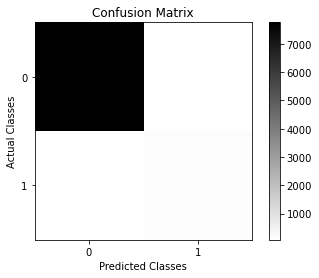

In [30]:
cm.plot()

In [32]:
print(cm)

Predict    0          1          
Actual
0          7758       72         

1          78         192        





Overall Statistics : 

95% CI                                                            (0.97855,0.98442)
ACC Macro                                                         0.98148
ARI                                                               0.69549
AUNP                                                              0.85096
AUNU                                                              0.85096
Bangdiwala B                                                      0.9804
Bennett S                                                         0.96296
CBA                                                               0.85058
CSI                                                               0.70962
Chi-Squared                                                       4078.32766
Chi-Squared DF                                                    1
Conditional Entropy                       

In [23]:
print(cm.overall_stat["F1 Macro"], cm.overall_stat["F1 Micro"])

0.7734150138896176 0.9523456790123457


In [26]:
for threshold in np.arange(0.94, 0.98, 0.001):
    predict_vector = (similarities > threshold) * 1
    cm = ConfusionMatrix(actual_vector, predict_vector)
    print(threshold, cm.overall_stat["F1 Macro"], cm.overall_stat["F1 Micro"])

0.94 0.81312213233808 0.967037037037037
0.941 0.8178096673339481 0.9683950617283951
0.942 0.8226966166428451 0.97
0.943 0.8223030548472146 0.9704938271604938
0.944 0.8259187620889749 0.971604938271605
0.945 0.8328065375931099 0.9733333333333334
0.946 0.8340170993705176 0.9738271604938271
0.947 0.8368378418866185 0.9745679012345679
0.948 0.8414257038628746 0.975679012345679
0.949 0.8405767994858612 0.9758024691358025
0.95 0.8424131539621054 0.9762962962962963
0.951 0.8472559709849202 0.9774074074074074
0.952 0.8493386071438871 0.9780246913580247
0.953 0.851781685583915 0.9788888888888889
0.954 0.8512755027320804 0.9792592592592593
0.955 0.8523734190648958 0.9801234567901235
0.956 0.8513157130409527 0.9804938271604938
0.957 0.8547631240344438 0.9814814814814815
0.958 0.8489992150706437 0.9812345679012345
0.959 0.8462737503662169 0.981358024691358
0.96 0.8452229299363057 0.9814814814814815
0.961 0.8451486996733274 0.9819753086419754
0.962 0.8449267843695089 0.9823456790123457
0.963 0.8445

In [ ]:
print(speech3)

In [14]:
inputs= feature_extractor(
  speech3, sampling_rate=16000, return_tensors="pt", padding=True
    )

with torch.no_grad():
    embeddings = model(**inputs).embeddings

embeddings = torch.nn.functional.normalize(embeddings, dim=-1).cpu()

# the resulting embeddings can be used for cosine similarity-based retrieval
cosine_sim = torch.nn.CosineSimilarity(dim=-1)
similarity = cosine_sim(embeddings[0], embeddings[1])
threshold = 0.9  # the optimal threshold is dataset-dependent
if similarity < threshold:
    print("Speakers are not the same!")
round(similarity.item(), 2)

Speakers are not the same!


0.69